# Configurações Iniciais

    - Importando bibliotecas necessárias

In [1]:
import random
import os
import shutil

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from tqdm import tqdm
from PIL import Image
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score, confusion_matrix, precision_recall_fscore_support

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split

import torchvision
from torchvision import datasets
import torchvision.models as models
from torchvision.transforms import v2
import torchvision.transforms.functional as TF

    - Definindo a seed
    - Setando o device
    - Criando a função de mostrar imagens

In [2]:
def set_seed(seed=1234):
    random.seed(seed)
    os.environ['PYHTONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

set_seed()
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [3]:
def imshow(img):
    plt.figure(figsize=(20,8))
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

---

# Definindo o Dataset
    - Definindo as imagens
    - Realizando as transformações - tiramos a normalização de cor pois estava prejudicando
    - Dividindo entre treino e teste
    - Comparar imagens com normalização | sem normalização

In [4]:
img_size = (299,299)

transformations = v2.Compose([
    v2.Resize(img_size), 
    v2.RandomHorizontalFlip(p=0.5),
    v2.RandomVerticalFlip(p=0.5),
    v2.RandomRotation(degrees=(0, 180)),
    v2.RandomPerspective(p=0.5),  v2.ToImage(), v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [5]:
dataset_dir = 'assets'
checkpoints_dir = ".ipynb_checkpoints"

if os.path.exists(checkpoints_dir):
    if os.path.isdir(checkpoints_dir):
        shutil.rmtree(checkpoints_dir)
    else:
        os.remove(checkpoints_dir)

print(os.listdir(dataset_dir))

dataset = datasets.ImageFolder(root=dataset_dir, transform=transformations)
print(os.listdir(dataset_dir))

['CoralFalsa', 'CoralVerdadeira']
['CoralFalsa', 'CoralVerdadeira']


In [6]:
train_ratio = 0.7
val_ratio = 0.15
test_ratio = 0.15

total_size = len(dataset)
train_size = int(train_ratio * total_size)
val_size = int(val_ratio * total_size)
test_size = total_size - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

print(f"Tamanho do conjunto de treino: {len(train_dataset)}")
print(f"Tamanho do conjunto de validação: {len(val_dataset)}")
print(f"Tamanho do conjunto de teste: {len(test_dataset)}")

Tamanho do conjunto de treino: 34
Tamanho do conjunto de validação: 7
Tamanho do conjunto de teste: 8


In [7]:
batch_size = 5

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"Número de batches no conjunto de treino: {len(train_loader)}")
print(f"Número de batches no conjunto de validação: {len(val_loader)}")
print(f"Número de batches no conjunto de teste: {len(test_loader)}")

Número de batches no conjunto de treino: 7
Número de batches no conjunto de validação: 2
Número de batches no conjunto de teste: 2


C:\Users\Cliente\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\transforms\v2\_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


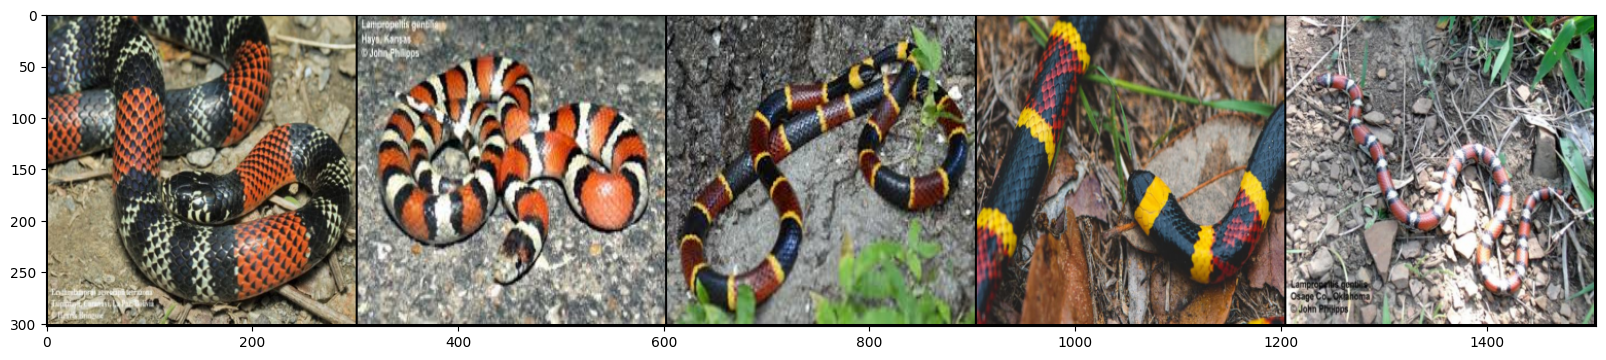

In [8]:
# SEM NORMALIZAÇÃO E TRANSFORMAÇÕES

no_transformations = v2.Compose([v2.Resize(img_size), v2.ToTensor()])
dataset_nt = datasets.ImageFolder(root=dataset_dir, transform=no_transformations)
nt_loader = DataLoader(dataset_nt,batch_size=batch_size, shuffle=True)

dataiter_nt = iter(nt_loader)
images_nt = next(dataiter_nt)
imshow(torchvision.utils.make_grid(images_nt[0]))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


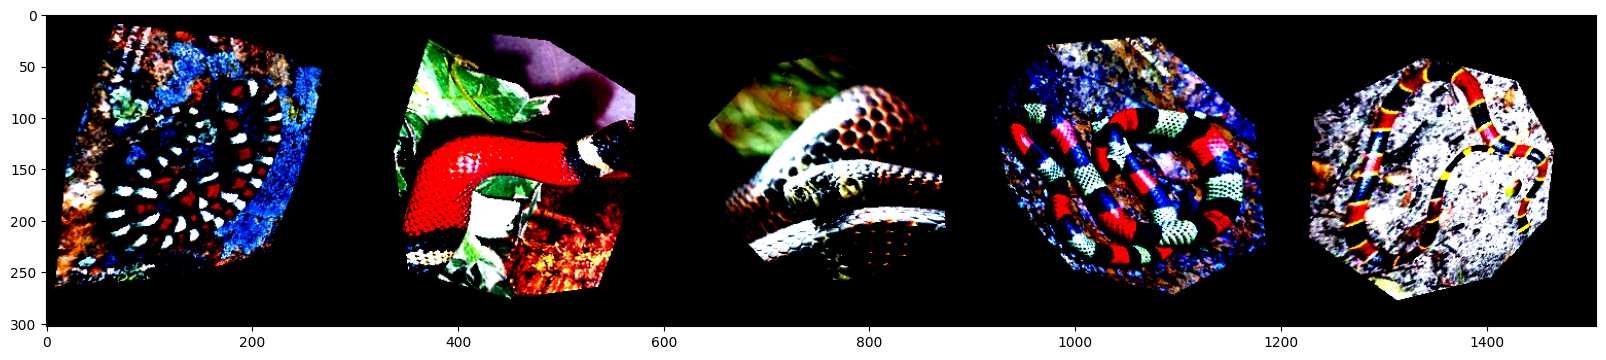

In [9]:
# COM NORMALIZAÇÃO E TRANSFORMAÇÕES

dataiter = iter(train_loader)
images = next(dataiter)
imshow(torchvision.utils.make_grid(images[0]))

---

# Definindo Funções

    - Comparação entre Loss de treino e validação
    - Validação
    - Treino
    - Métricas de Avaliação

In [10]:
def plot_comparison(train_losses, val_losses):
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training e Validation Loss')
    plt.legend()
    plt.show()

In [11]:
def plot_equation(train_losses, val_losses):
    epochs = np.arange(len(train_losses))
    
    train_fit = np.polyfit(epochs, train_losses, 3)
    train_fit_fn = np.poly1d(train_fit)
    
    val_fit = np.polyfit(epochs, val_losses, 3)
    val_fit_fn = np.poly1d(val_fit)
    
    plt.plot(epochs, train_fit_fn(epochs), color='blue', linestyle='--', label='Train Fit')
    plt.plot(epochs, val_fit_fn(epochs), color='red', linestyle='--', label='Validation Fit')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training e Validation Loss')
    plt.legend()
    plt.show()

In [12]:
def validation(model, loader, criterion):
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for data in loader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            
            outputs = model(images)
            if isinstance(outputs, torchvision.models.inception.InceptionOutputs):
                outputs = outputs.logits
            
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_loss /= len(loader)
    return val_loss

In [13]:
def train(model, train_loader, val_loader, optimizer, criterion, epochs, early_stop_patience, model_save_path, print_freq=1):
    best_val_loss = float('inf')
    patience_counter = 0
    train_losses = []
    val_losses = []
    
    for epoch in range(1, epochs + 1):
        model.train()
        running_loss = 0.0
        for data in tqdm(train_loader, desc=f'Epoch {epoch}/{epochs}'):
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            
            outputs = model(images)
            if isinstance(outputs, torchvision.models.inception.InceptionOutputs):
                outputs = outputs.logits
            
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            
        epoch_loss = running_loss / len(train_loader)
        train_losses.append(epoch_loss)
        
        if epoch % print_freq == 0:
            val_loss = validation(model, val_loader, criterion)
            val_losses.append(val_loss)
            print(f'Epoch: {epoch} | Train Loss: {epoch_loss:.4f} | Val Loss: {val_loss:.4f}')

            if val_loss >= best_val_loss:
                patience_counter += 1
                if patience_counter >= early_stop_patience:
                    print(f'Validation loss parou de melhorar após {early_stop_patience} epochs. Early stopping!')
                    break
            else:
                patience_counter = 0
                torch.save(model.state_dict(), model_save_path)
                best_val_loss = val_loss
    return train_losses, val_losses

In [14]:
def evaluate_model(model, loader):
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for data in loader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            
            outputs = model(images)
            if isinstance(outputs, torchvision.models.inception.InceptionOutputs):
                outputs = outputs.logits
            
            _, preds = torch.max(outputs, 1)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    return all_preds, all_labels

In [15]:
def calculate_metrics(preds, labels):
    acc = accuracy_score(labels, preds)
    cm = confusion_matrix(labels, preds)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted')
    
    return acc, cm, precision, recall, f1

In [16]:
def print_results(acc, cm, precision, recall, f1):
    print(f'Acurácia: {accuracy:.4f}')
    print(f'Matriz de Confusão:\n{conf_matrix}')
    print(f'Precisão: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'F1 Score: {f1_score:.4f}')

---

# Treinando Modelos

    - Definindo o modelo
    - Definir quantidade de classes de saída
    - Congelar pesos das camadas
    - Definir pesos por conta da má distribuição entre classes
    - Definir parâmetros
    - Treinar e verificar resultado

In [17]:
targets = [label for _, label in dataset]
class_weights = compute_class_weight('balanced', classes=np.unique(targets), y=targets)
class_weights = torch.tensor(class_weights, dtype=torch.float32).to(device)

In [18]:
criterion = nn.CrossEntropyLoss(weight=class_weights)
early_stop_patience = 20
epochs = 300
lr = 0.0001
optimizer = 'Adam'

 ## Modelo 1 - RESNET

In [19]:
resnet = torchvision.models.resnet50(weights = torchvision.models.ResNet50_Weights.DEFAULT)

In [20]:
resnet.fc = nn.Linear(2048,2)

In [21]:
for name, params in resnet.named_parameters():
    if name not in ('fc.weight', 'fc.bias'):
        params.requires_grad = False

In [22]:
resnet.to(device)
optimizer = optim.Adam(resnet.parameters(), lr=0.0001)
model_save_path = 'top_resnet'

In [23]:
train_losses, val_losses = train(resnet, train_loader, val_loader, optimizer, criterion, epochs, early_stop_patience, model_save_path)

Epoch 1/300: 100%|███████████████████████████████████████████████████████████████████████| 7/7 [00:04<00:00,  1.59it/s]


Epoch: 1 | Train Loss: 0.6790 | Val Loss: 0.7422


Epoch 2/300: 100%|███████████████████████████████████████████████████████████████████████| 7/7 [00:04<00:00,  1.52it/s]


Epoch: 2 | Train Loss: 0.7016 | Val Loss: 0.7841


Epoch 3/300: 100%|███████████████████████████████████████████████████████████████████████| 7/7 [00:04<00:00,  1.51it/s]


Epoch: 3 | Train Loss: 0.6752 | Val Loss: 0.7568


Epoch 4/300: 100%|███████████████████████████████████████████████████████████████████████| 7/7 [00:04<00:00,  1.54it/s]


Epoch: 4 | Train Loss: 0.6649 | Val Loss: 0.6900


Epoch 5/300: 100%|███████████████████████████████████████████████████████████████████████| 7/7 [00:04<00:00,  1.52it/s]


Epoch: 5 | Train Loss: 0.6633 | Val Loss: 0.6735


Epoch 6/300: 100%|███████████████████████████████████████████████████████████████████████| 7/7 [00:04<00:00,  1.59it/s]


Epoch: 6 | Train Loss: 0.6793 | Val Loss: 0.6944


Epoch 7/300: 100%|███████████████████████████████████████████████████████████████████████| 7/7 [00:04<00:00,  1.56it/s]


Epoch: 7 | Train Loss: 0.6761 | Val Loss: 0.6910


Epoch 8/300: 100%|███████████████████████████████████████████████████████████████████████| 7/7 [00:04<00:00,  1.56it/s]


Epoch: 8 | Train Loss: 0.6458 | Val Loss: 0.6956


Epoch 9/300: 100%|███████████████████████████████████████████████████████████████████████| 7/7 [00:04<00:00,  1.57it/s]


Epoch: 9 | Train Loss: 0.6334 | Val Loss: 0.7256


Epoch 10/300: 100%|██████████████████████████████████████████████████████████████████████| 7/7 [00:04<00:00,  1.54it/s]


Epoch: 10 | Train Loss: 0.6569 | Val Loss: 0.6950


Epoch 11/300: 100%|██████████████████████████████████████████████████████████████████████| 7/7 [00:04<00:00,  1.58it/s]


Epoch: 11 | Train Loss: 0.6549 | Val Loss: 0.7008


Epoch 12/300: 100%|██████████████████████████████████████████████████████████████████████| 7/7 [00:04<00:00,  1.56it/s]


Epoch: 12 | Train Loss: 0.6331 | Val Loss: 0.6775


Epoch 13/300: 100%|██████████████████████████████████████████████████████████████████████| 7/7 [00:04<00:00,  1.65it/s]


Epoch: 13 | Train Loss: 0.6295 | Val Loss: 0.6751


Epoch 14/300: 100%|██████████████████████████████████████████████████████████████████████| 7/7 [00:04<00:00,  1.59it/s]


Epoch: 14 | Train Loss: 0.6496 | Val Loss: 0.7173


Epoch 15/300: 100%|██████████████████████████████████████████████████████████████████████| 7/7 [00:04<00:00,  1.64it/s]


Epoch: 15 | Train Loss: 0.6105 | Val Loss: 0.7319


Epoch 16/300: 100%|██████████████████████████████████████████████████████████████████████| 7/7 [00:04<00:00,  1.58it/s]


Epoch: 16 | Train Loss: 0.6148 | Val Loss: 0.6451


Epoch 17/300: 100%|██████████████████████████████████████████████████████████████████████| 7/7 [00:04<00:00,  1.51it/s]


Epoch: 17 | Train Loss: 0.5939 | Val Loss: 0.6757


Epoch 18/300: 100%|██████████████████████████████████████████████████████████████████████| 7/7 [00:04<00:00,  1.54it/s]


Epoch: 18 | Train Loss: 0.6128 | Val Loss: 0.6651


Epoch 19/300: 100%|██████████████████████████████████████████████████████████████████████| 7/7 [00:04<00:00,  1.58it/s]


Epoch: 19 | Train Loss: 0.6007 | Val Loss: 0.6564


Epoch 20/300: 100%|██████████████████████████████████████████████████████████████████████| 7/7 [00:04<00:00,  1.56it/s]


Epoch: 20 | Train Loss: 0.6238 | Val Loss: 0.6709


Epoch 21/300: 100%|██████████████████████████████████████████████████████████████████████| 7/7 [00:04<00:00,  1.60it/s]


Epoch: 21 | Train Loss: 0.5945 | Val Loss: 0.6844


Epoch 22/300: 100%|██████████████████████████████████████████████████████████████████████| 7/7 [00:04<00:00,  1.60it/s]


Epoch: 22 | Train Loss: 0.5931 | Val Loss: 0.6552


Epoch 23/300: 100%|██████████████████████████████████████████████████████████████████████| 7/7 [00:04<00:00,  1.54it/s]


Epoch: 23 | Train Loss: 0.5834 | Val Loss: 0.6634


Epoch 24/300: 100%|██████████████████████████████████████████████████████████████████████| 7/7 [00:04<00:00,  1.58it/s]


Epoch: 24 | Train Loss: 0.5622 | Val Loss: 0.6812


Epoch 25/300: 100%|██████████████████████████████████████████████████████████████████████| 7/7 [00:04<00:00,  1.54it/s]


Epoch: 25 | Train Loss: 0.5587 | Val Loss: 0.6755


Epoch 26/300: 100%|██████████████████████████████████████████████████████████████████████| 7/7 [00:04<00:00,  1.61it/s]


Epoch: 26 | Train Loss: 0.5863 | Val Loss: 0.6542


Epoch 27/300: 100%|██████████████████████████████████████████████████████████████████████| 7/7 [00:04<00:00,  1.55it/s]


Epoch: 27 | Train Loss: 0.5874 | Val Loss: 0.6861


Epoch 28/300: 100%|██████████████████████████████████████████████████████████████████████| 7/7 [00:04<00:00,  1.56it/s]


Epoch: 28 | Train Loss: 0.5730 | Val Loss: 0.6363


Epoch 29/300: 100%|██████████████████████████████████████████████████████████████████████| 7/7 [00:04<00:00,  1.56it/s]


Epoch: 29 | Train Loss: 0.5503 | Val Loss: 0.6238


Epoch 30/300: 100%|██████████████████████████████████████████████████████████████████████| 7/7 [00:04<00:00,  1.52it/s]


Epoch: 30 | Train Loss: 0.5543 | Val Loss: 0.6004


Epoch 31/300: 100%|██████████████████████████████████████████████████████████████████████| 7/7 [00:04<00:00,  1.52it/s]


Epoch: 31 | Train Loss: 0.5781 | Val Loss: 0.6124


Epoch 32/300: 100%|██████████████████████████████████████████████████████████████████████| 7/7 [00:04<00:00,  1.55it/s]


Epoch: 32 | Train Loss: 0.5291 | Val Loss: 0.6413


Epoch 33/300: 100%|██████████████████████████████████████████████████████████████████████| 7/7 [00:04<00:00,  1.54it/s]


Epoch: 33 | Train Loss: 0.5303 | Val Loss: 0.6165


Epoch 34/300: 100%|██████████████████████████████████████████████████████████████████████| 7/7 [00:04<00:00,  1.55it/s]


Epoch: 34 | Train Loss: 0.5140 | Val Loss: 0.6184


Epoch 35/300: 100%|██████████████████████████████████████████████████████████████████████| 7/7 [00:04<00:00,  1.52it/s]


Epoch: 35 | Train Loss: 0.5092 | Val Loss: 0.6089


Epoch 36/300: 100%|██████████████████████████████████████████████████████████████████████| 7/7 [00:04<00:00,  1.60it/s]


Epoch: 36 | Train Loss: 0.5034 | Val Loss: 0.6663


Epoch 37/300: 100%|██████████████████████████████████████████████████████████████████████| 7/7 [00:04<00:00,  1.62it/s]


Epoch: 37 | Train Loss: 0.5263 | Val Loss: 0.5948


Epoch 38/300: 100%|██████████████████████████████████████████████████████████████████████| 7/7 [00:04<00:00,  1.48it/s]


Epoch: 38 | Train Loss: 0.5473 | Val Loss: 0.6453


Epoch 39/300: 100%|██████████████████████████████████████████████████████████████████████| 7/7 [00:04<00:00,  1.54it/s]


Epoch: 39 | Train Loss: 0.5204 | Val Loss: 0.6246


Epoch 40/300: 100%|██████████████████████████████████████████████████████████████████████| 7/7 [00:04<00:00,  1.57it/s]


Epoch: 40 | Train Loss: 0.5251 | Val Loss: 0.6477


Epoch 41/300: 100%|██████████████████████████████████████████████████████████████████████| 7/7 [00:04<00:00,  1.60it/s]


Epoch: 41 | Train Loss: 0.5223 | Val Loss: 0.6593


Epoch 42/300: 100%|██████████████████████████████████████████████████████████████████████| 7/7 [00:04<00:00,  1.58it/s]


Epoch: 42 | Train Loss: 0.4988 | Val Loss: 0.6145


Epoch 43/300: 100%|██████████████████████████████████████████████████████████████████████| 7/7 [00:04<00:00,  1.57it/s]


Epoch: 43 | Train Loss: 0.5547 | Val Loss: 0.5627


Epoch 44/300: 100%|██████████████████████████████████████████████████████████████████████| 7/7 [00:04<00:00,  1.51it/s]


Epoch: 44 | Train Loss: 0.5140 | Val Loss: 0.6169


Epoch 45/300: 100%|██████████████████████████████████████████████████████████████████████| 7/7 [00:04<00:00,  1.55it/s]


Epoch: 45 | Train Loss: 0.4692 | Val Loss: 0.6219


Epoch 46/300: 100%|██████████████████████████████████████████████████████████████████████| 7/7 [00:04<00:00,  1.55it/s]


Epoch: 46 | Train Loss: 0.4940 | Val Loss: 0.6405


Epoch 47/300: 100%|██████████████████████████████████████████████████████████████████████| 7/7 [00:04<00:00,  1.55it/s]


Epoch: 47 | Train Loss: 0.5207 | Val Loss: 0.6266


Epoch 48/300: 100%|██████████████████████████████████████████████████████████████████████| 7/7 [00:04<00:00,  1.53it/s]


Epoch: 48 | Train Loss: 0.4863 | Val Loss: 0.6192


Epoch 49/300: 100%|██████████████████████████████████████████████████████████████████████| 7/7 [00:04<00:00,  1.47it/s]


Epoch: 49 | Train Loss: 0.4640 | Val Loss: 0.6165


Epoch 50/300: 100%|██████████████████████████████████████████████████████████████████████| 7/7 [00:04<00:00,  1.57it/s]


Epoch: 50 | Train Loss: 0.4562 | Val Loss: 0.5980


Epoch 51/300: 100%|██████████████████████████████████████████████████████████████████████| 7/7 [00:04<00:00,  1.42it/s]


Epoch: 51 | Train Loss: 0.4680 | Val Loss: 0.6210


Epoch 52/300: 100%|██████████████████████████████████████████████████████████████████████| 7/7 [00:04<00:00,  1.46it/s]


Epoch: 52 | Train Loss: 0.4608 | Val Loss: 0.5975


Epoch 53/300: 100%|██████████████████████████████████████████████████████████████████████| 7/7 [00:04<00:00,  1.43it/s]


Epoch: 53 | Train Loss: 0.4995 | Val Loss: 0.5511


Epoch 54/300: 100%|██████████████████████████████████████████████████████████████████████| 7/7 [00:04<00:00,  1.48it/s]


Epoch: 54 | Train Loss: 0.4915 | Val Loss: 0.5928


Epoch 55/300: 100%|██████████████████████████████████████████████████████████████████████| 7/7 [00:04<00:00,  1.41it/s]


Epoch: 55 | Train Loss: 0.4712 | Val Loss: 0.6027


Epoch 56/300: 100%|██████████████████████████████████████████████████████████████████████| 7/7 [00:04<00:00,  1.44it/s]


Epoch: 56 | Train Loss: 0.4649 | Val Loss: 0.5853


Epoch 57/300: 100%|██████████████████████████████████████████████████████████████████████| 7/7 [00:04<00:00,  1.44it/s]


Epoch: 57 | Train Loss: 0.4479 | Val Loss: 0.5606


Epoch 58/300: 100%|██████████████████████████████████████████████████████████████████████| 7/7 [00:04<00:00,  1.46it/s]


Epoch: 58 | Train Loss: 0.4478 | Val Loss: 0.6137


Epoch 59/300: 100%|██████████████████████████████████████████████████████████████████████| 7/7 [00:04<00:00,  1.50it/s]


Epoch: 59 | Train Loss: 0.4459 | Val Loss: 0.6030


Epoch 60/300: 100%|██████████████████████████████████████████████████████████████████████| 7/7 [00:04<00:00,  1.60it/s]


Epoch: 60 | Train Loss: 0.4743 | Val Loss: 0.6005


Epoch 61/300: 100%|██████████████████████████████████████████████████████████████████████| 7/7 [00:04<00:00,  1.60it/s]


Epoch: 61 | Train Loss: 0.4696 | Val Loss: 0.5416


Epoch 62/300: 100%|██████████████████████████████████████████████████████████████████████| 7/7 [00:04<00:00,  1.50it/s]


Epoch: 62 | Train Loss: 0.4412 | Val Loss: 0.5976


Epoch 63/300: 100%|██████████████████████████████████████████████████████████████████████| 7/7 [00:04<00:00,  1.56it/s]


Epoch: 63 | Train Loss: 0.4348 | Val Loss: 0.5855


Epoch 64/300: 100%|██████████████████████████████████████████████████████████████████████| 7/7 [00:04<00:00,  1.58it/s]


Epoch: 64 | Train Loss: 0.5007 | Val Loss: 0.6132


Epoch 65/300: 100%|██████████████████████████████████████████████████████████████████████| 7/7 [00:04<00:00,  1.55it/s]


Epoch: 65 | Train Loss: 0.4104 | Val Loss: 0.5944


Epoch 66/300: 100%|██████████████████████████████████████████████████████████████████████| 7/7 [00:04<00:00,  1.51it/s]


Epoch: 66 | Train Loss: 0.4144 | Val Loss: 0.6098


Epoch 67/300: 100%|██████████████████████████████████████████████████████████████████████| 7/7 [00:04<00:00,  1.59it/s]


Epoch: 67 | Train Loss: 0.4574 | Val Loss: 0.6067


Epoch 68/300: 100%|██████████████████████████████████████████████████████████████████████| 7/7 [00:04<00:00,  1.64it/s]


Epoch: 68 | Train Loss: 0.4555 | Val Loss: 0.6281


Epoch 69/300: 100%|██████████████████████████████████████████████████████████████████████| 7/7 [00:04<00:00,  1.61it/s]


Epoch: 69 | Train Loss: 0.4383 | Val Loss: 0.6087


Epoch 70/300: 100%|██████████████████████████████████████████████████████████████████████| 7/7 [00:04<00:00,  1.59it/s]


Epoch: 70 | Train Loss: 0.4637 | Val Loss: 0.5521


Epoch 71/300: 100%|██████████████████████████████████████████████████████████████████████| 7/7 [00:04<00:00,  1.55it/s]


Epoch: 71 | Train Loss: 0.3864 | Val Loss: 0.6245


Epoch 72/300: 100%|██████████████████████████████████████████████████████████████████████| 7/7 [00:04<00:00,  1.55it/s]


Epoch: 72 | Train Loss: 0.4191 | Val Loss: 0.5086


Epoch 73/300: 100%|██████████████████████████████████████████████████████████████████████| 7/7 [00:04<00:00,  1.51it/s]


Epoch: 73 | Train Loss: 0.3954 | Val Loss: 0.6211


Epoch 74/300: 100%|██████████████████████████████████████████████████████████████████████| 7/7 [00:04<00:00,  1.55it/s]


Epoch: 74 | Train Loss: 0.4074 | Val Loss: 0.5322


Epoch 75/300: 100%|██████████████████████████████████████████████████████████████████████| 7/7 [00:04<00:00,  1.57it/s]


Epoch: 75 | Train Loss: 0.3850 | Val Loss: 0.5542


Epoch 76/300: 100%|██████████████████████████████████████████████████████████████████████| 7/7 [00:04<00:00,  1.56it/s]


Epoch: 76 | Train Loss: 0.4290 | Val Loss: 0.5772


Epoch 77/300: 100%|██████████████████████████████████████████████████████████████████████| 7/7 [00:04<00:00,  1.50it/s]


Epoch: 77 | Train Loss: 0.4242 | Val Loss: 0.5607


Epoch 78/300: 100%|██████████████████████████████████████████████████████████████████████| 7/7 [00:04<00:00,  1.49it/s]


Epoch: 78 | Train Loss: 0.4091 | Val Loss: 0.5695


Epoch 79/300: 100%|██████████████████████████████████████████████████████████████████████| 7/7 [00:04<00:00,  1.50it/s]


Epoch: 79 | Train Loss: 0.4029 | Val Loss: 0.5800


Epoch 80/300: 100%|██████████████████████████████████████████████████████████████████████| 7/7 [00:04<00:00,  1.57it/s]


Epoch: 80 | Train Loss: 0.4170 | Val Loss: 0.5871


Epoch 81/300: 100%|██████████████████████████████████████████████████████████████████████| 7/7 [00:04<00:00,  1.56it/s]


Epoch: 81 | Train Loss: 0.3697 | Val Loss: 0.5423


Epoch 82/300: 100%|██████████████████████████████████████████████████████████████████████| 7/7 [00:04<00:00,  1.57it/s]


Epoch: 82 | Train Loss: 0.3765 | Val Loss: 0.5533


Epoch 83/300: 100%|██████████████████████████████████████████████████████████████████████| 7/7 [00:04<00:00,  1.58it/s]


Epoch: 83 | Train Loss: 0.3666 | Val Loss: 0.5672


Epoch 84/300: 100%|██████████████████████████████████████████████████████████████████████| 7/7 [00:04<00:00,  1.59it/s]


Epoch: 84 | Train Loss: 0.4206 | Val Loss: 0.5835


Epoch 85/300: 100%|██████████████████████████████████████████████████████████████████████| 7/7 [00:04<00:00,  1.52it/s]


Epoch: 85 | Train Loss: 0.4056 | Val Loss: 0.5988


Epoch 86/300: 100%|██████████████████████████████████████████████████████████████████████| 7/7 [00:04<00:00,  1.59it/s]


Epoch: 86 | Train Loss: 0.3904 | Val Loss: 0.5595


Epoch 87/300: 100%|██████████████████████████████████████████████████████████████████████| 7/7 [00:04<00:00,  1.58it/s]


Epoch: 87 | Train Loss: 0.4098 | Val Loss: 0.5448


Epoch 88/300: 100%|██████████████████████████████████████████████████████████████████████| 7/7 [00:04<00:00,  1.55it/s]


Epoch: 88 | Train Loss: 0.3917 | Val Loss: 0.5246


Epoch 89/300: 100%|██████████████████████████████████████████████████████████████████████| 7/7 [00:04<00:00,  1.67it/s]


Epoch: 89 | Train Loss: 0.4377 | Val Loss: 0.5246


Epoch 90/300: 100%|██████████████████████████████████████████████████████████████████████| 7/7 [00:04<00:00,  1.55it/s]


Epoch: 90 | Train Loss: 0.3901 | Val Loss: 0.5199


Epoch 91/300: 100%|██████████████████████████████████████████████████████████████████████| 7/7 [00:04<00:00,  1.63it/s]


Epoch: 91 | Train Loss: 0.3460 | Val Loss: 0.5386


Epoch 92/300: 100%|██████████████████████████████████████████████████████████████████████| 7/7 [00:04<00:00,  1.53it/s]


Epoch: 92 | Train Loss: 0.3707 | Val Loss: 0.5429


Epoch 93/300: 100%|██████████████████████████████████████████████████████████████████████| 7/7 [00:04<00:00,  1.54it/s]


Epoch: 93 | Train Loss: 0.3721 | Val Loss: 0.5202


Epoch 94/300: 100%|██████████████████████████████████████████████████████████████████████| 7/7 [00:04<00:00,  1.61it/s]


Epoch: 94 | Train Loss: 0.3953 | Val Loss: 0.5562


Epoch 95/300: 100%|██████████████████████████████████████████████████████████████████████| 7/7 [00:04<00:00,  1.56it/s]


Epoch: 95 | Train Loss: 0.3596 | Val Loss: 0.5153


Epoch 96/300: 100%|██████████████████████████████████████████████████████████████████████| 7/7 [00:04<00:00,  1.55it/s]


Epoch: 96 | Train Loss: 0.3853 | Val Loss: 0.6343


Epoch 97/300: 100%|██████████████████████████████████████████████████████████████████████| 7/7 [00:04<00:00,  1.49it/s]


Epoch: 97 | Train Loss: 0.3526 | Val Loss: 0.6217


Epoch 98/300: 100%|██████████████████████████████████████████████████████████████████████| 7/7 [00:04<00:00,  1.58it/s]


Epoch: 98 | Train Loss: 0.3977 | Val Loss: 0.5053


Epoch 99/300: 100%|██████████████████████████████████████████████████████████████████████| 7/7 [00:04<00:00,  1.55it/s]


Epoch: 99 | Train Loss: 0.3696 | Val Loss: 0.5513


Epoch 100/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:04<00:00,  1.54it/s]


Epoch: 100 | Train Loss: 0.4033 | Val Loss: 0.5210


Epoch 101/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:04<00:00,  1.47it/s]


Epoch: 101 | Train Loss: 0.3702 | Val Loss: 0.5457


Epoch 102/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:04<00:00,  1.62it/s]


Epoch: 102 | Train Loss: 0.3423 | Val Loss: 0.5737


Epoch 103/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:04<00:00,  1.54it/s]


Epoch: 103 | Train Loss: 0.3609 | Val Loss: 0.5282


Epoch 104/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:04<00:00,  1.56it/s]


Epoch: 104 | Train Loss: 0.4095 | Val Loss: 0.5814


Epoch 105/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:04<00:00,  1.62it/s]


Epoch: 105 | Train Loss: 0.3739 | Val Loss: 0.5302


Epoch 106/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:04<00:00,  1.55it/s]


Epoch: 106 | Train Loss: 0.3384 | Val Loss: 0.5758


Epoch 107/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:04<00:00,  1.51it/s]


Epoch: 107 | Train Loss: 0.4073 | Val Loss: 0.5355


Epoch 108/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:04<00:00,  1.59it/s]


Epoch: 108 | Train Loss: 0.2984 | Val Loss: 0.5178


Epoch 109/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:04<00:00,  1.65it/s]


Epoch: 109 | Train Loss: 0.3528 | Val Loss: 0.5650


Epoch 110/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:04<00:00,  1.54it/s]


Epoch: 110 | Train Loss: 0.3849 | Val Loss: 0.5644


Epoch 111/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:04<00:00,  1.55it/s]


Epoch: 111 | Train Loss: 0.3819 | Val Loss: 0.5178


Epoch 112/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:04<00:00,  1.63it/s]


Epoch: 112 | Train Loss: 0.3945 | Val Loss: 0.5445


Epoch 113/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:04<00:00,  1.56it/s]


Epoch: 113 | Train Loss: 0.3151 | Val Loss: 0.5840


Epoch 114/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:04<00:00,  1.57it/s]


Epoch: 114 | Train Loss: 0.3816 | Val Loss: 0.5845


Epoch 115/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:04<00:00,  1.52it/s]


Epoch: 115 | Train Loss: 0.4267 | Val Loss: 0.5526


Epoch 116/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:04<00:00,  1.54it/s]


Epoch: 116 | Train Loss: 0.3464 | Val Loss: 0.5064


Epoch 117/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:04<00:00,  1.55it/s]


Epoch: 117 | Train Loss: 0.3241 | Val Loss: 0.5771


Epoch 118/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:04<00:00,  1.55it/s]


Epoch: 118 | Train Loss: 0.3219 | Val Loss: 0.5140


Epoch 119/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:04<00:00,  1.58it/s]


Epoch: 119 | Train Loss: 0.3479 | Val Loss: 0.5565


Epoch 120/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:04<00:00,  1.58it/s]


Epoch: 120 | Train Loss: 0.3649 | Val Loss: 0.6103


Epoch 121/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:04<00:00,  1.64it/s]


Epoch: 121 | Train Loss: 0.3346 | Val Loss: 0.5010


Epoch 122/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:04<00:00,  1.51it/s]


Epoch: 122 | Train Loss: 0.3007 | Val Loss: 0.4809


Epoch 123/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:04<00:00,  1.54it/s]


Epoch: 123 | Train Loss: 0.3422 | Val Loss: 0.5606


Epoch 124/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:04<00:00,  1.53it/s]


Epoch: 124 | Train Loss: 0.2952 | Val Loss: 0.5008


Epoch 125/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:04<00:00,  1.55it/s]


Epoch: 125 | Train Loss: 0.2955 | Val Loss: 0.5310


Epoch 126/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:04<00:00,  1.56it/s]


Epoch: 126 | Train Loss: 0.2893 | Val Loss: 0.5287


Epoch 127/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:04<00:00,  1.54it/s]


Epoch: 127 | Train Loss: 0.3631 | Val Loss: 0.5499


Epoch 128/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:04<00:00,  1.60it/s]


Epoch: 128 | Train Loss: 0.3988 | Val Loss: 0.5801


Epoch 129/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:04<00:00,  1.59it/s]


Epoch: 129 | Train Loss: 0.3350 | Val Loss: 0.5176


Epoch 130/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:04<00:00,  1.56it/s]


Epoch: 130 | Train Loss: 0.3473 | Val Loss: 0.5416


Epoch 131/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:04<00:00,  1.65it/s]


Epoch: 131 | Train Loss: 0.3703 | Val Loss: 0.5208


Epoch 132/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:04<00:00,  1.60it/s]


Epoch: 132 | Train Loss: 0.2954 | Val Loss: 0.5102


Epoch 133/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:04<00:00,  1.62it/s]


Epoch: 133 | Train Loss: 0.3557 | Val Loss: 0.4461


Epoch 134/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:04<00:00,  1.51it/s]


Epoch: 134 | Train Loss: 0.3674 | Val Loss: 0.5151


Epoch 135/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:04<00:00,  1.58it/s]


Epoch: 135 | Train Loss: 0.3265 | Val Loss: 0.4933


Epoch 136/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:04<00:00,  1.58it/s]


Epoch: 136 | Train Loss: 0.2688 | Val Loss: 0.5079


Epoch 137/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:04<00:00,  1.52it/s]


Epoch: 137 | Train Loss: 0.3078 | Val Loss: 0.5362


Epoch 138/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:04<00:00,  1.55it/s]


Epoch: 138 | Train Loss: 0.3108 | Val Loss: 0.4755


Epoch 139/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:04<00:00,  1.58it/s]


Epoch: 139 | Train Loss: 0.3654 | Val Loss: 0.4921


Epoch 140/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:04<00:00,  1.62it/s]


Epoch: 140 | Train Loss: 0.2934 | Val Loss: 0.5037


Epoch 141/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:04<00:00,  1.59it/s]


Epoch: 141 | Train Loss: 0.3098 | Val Loss: 0.5280


Epoch 142/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:04<00:00,  1.63it/s]


Epoch: 142 | Train Loss: 0.3290 | Val Loss: 0.5755


Epoch 143/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:04<00:00,  1.60it/s]


Epoch: 143 | Train Loss: 0.2784 | Val Loss: 0.5849


Epoch 144/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:04<00:00,  1.53it/s]


Epoch: 144 | Train Loss: 0.3076 | Val Loss: 0.5607


Epoch 145/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:04<00:00,  1.66it/s]


Epoch: 145 | Train Loss: 0.2884 | Val Loss: 0.5173


Epoch 146/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:04<00:00,  1.63it/s]


Epoch: 146 | Train Loss: 0.2963 | Val Loss: 0.5121


Epoch 147/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:04<00:00,  1.56it/s]


Epoch: 147 | Train Loss: 0.3416 | Val Loss: 0.5492


Epoch 148/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:04<00:00,  1.54it/s]


Epoch: 148 | Train Loss: 0.2896 | Val Loss: 0.5535


Epoch 149/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:04<00:00,  1.60it/s]


Epoch: 149 | Train Loss: 0.3535 | Val Loss: 0.5497


Epoch 150/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:04<00:00,  1.57it/s]


Epoch: 150 | Train Loss: 0.3242 | Val Loss: 0.4572


Epoch 151/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:04<00:00,  1.59it/s]


Epoch: 151 | Train Loss: 0.2845 | Val Loss: 0.4821


Epoch 152/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:04<00:00,  1.61it/s]


Epoch: 152 | Train Loss: 0.3274 | Val Loss: 0.4462


Epoch 153/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:04<00:00,  1.56it/s]


Epoch: 153 | Train Loss: 0.2793 | Val Loss: 0.5377


Epoch 154/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:04<00:00,  1.57it/s]


Epoch: 154 | Train Loss: 0.2605 | Val Loss: 0.5815


Epoch 155/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:04<00:00,  1.55it/s]


Epoch: 155 | Train Loss: 0.3010 | Val Loss: 0.4695


Epoch 156/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:04<00:00,  1.52it/s]


Epoch: 156 | Train Loss: 0.2811 | Val Loss: 0.6245


Epoch 157/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:04<00:00,  1.57it/s]


Epoch: 157 | Train Loss: 0.3296 | Val Loss: 0.4657


Epoch 158/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:04<00:00,  1.60it/s]


Epoch: 158 | Train Loss: 0.3099 | Val Loss: 0.4835


Epoch 159/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:04<00:00,  1.59it/s]


Epoch: 159 | Train Loss: 0.2586 | Val Loss: 0.4997


Epoch 160/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:04<00:00,  1.54it/s]


Epoch: 160 | Train Loss: 0.2671 | Val Loss: 0.4777


Epoch 161/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:04<00:00,  1.46it/s]


Epoch: 161 | Train Loss: 0.2985 | Val Loss: 0.4077


Epoch 162/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:04<00:00,  1.43it/s]


Epoch: 162 | Train Loss: 0.3081 | Val Loss: 0.4452


Epoch 163/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:04<00:00,  1.49it/s]


Epoch: 163 | Train Loss: 0.2793 | Val Loss: 0.4757


Epoch 164/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:04<00:00,  1.48it/s]


Epoch: 164 | Train Loss: 0.2316 | Val Loss: 0.4794


Epoch 165/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:04<00:00,  1.46it/s]


Epoch: 165 | Train Loss: 0.2573 | Val Loss: 0.4858


Epoch 166/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:04<00:00,  1.44it/s]


Epoch: 166 | Train Loss: 0.2433 | Val Loss: 0.4869


Epoch 167/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:04<00:00,  1.47it/s]


Epoch: 167 | Train Loss: 0.2497 | Val Loss: 0.4504


Epoch 168/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:04<00:00,  1.51it/s]


Epoch: 168 | Train Loss: 0.2520 | Val Loss: 0.4606


Epoch 169/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:04<00:00,  1.49it/s]


Epoch: 169 | Train Loss: 0.2901 | Val Loss: 0.4853


Epoch 170/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:04<00:00,  1.48it/s]


Epoch: 170 | Train Loss: 0.2963 | Val Loss: 0.5379


Epoch 171/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:04<00:00,  1.49it/s]


Epoch: 171 | Train Loss: 0.2648 | Val Loss: 0.3958


Epoch 172/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:04<00:00,  1.48it/s]


Epoch: 172 | Train Loss: 0.2392 | Val Loss: 0.3867


Epoch 173/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:04<00:00,  1.50it/s]


Epoch: 173 | Train Loss: 0.2594 | Val Loss: 0.5410


Epoch 174/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:04<00:00,  1.48it/s]


Epoch: 174 | Train Loss: 0.2958 | Val Loss: 0.4640


Epoch 175/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:04<00:00,  1.48it/s]


Epoch: 175 | Train Loss: 0.2846 | Val Loss: 0.4302


Epoch 176/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:04<00:00,  1.51it/s]


Epoch: 176 | Train Loss: 0.2927 | Val Loss: 0.5235


Epoch 177/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:04<00:00,  1.55it/s]


Epoch: 177 | Train Loss: 0.2751 | Val Loss: 0.5796


Epoch 178/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:04<00:00,  1.51it/s]


Epoch: 178 | Train Loss: 0.3206 | Val Loss: 0.5041


Epoch 179/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:04<00:00,  1.54it/s]


Epoch: 179 | Train Loss: 0.2652 | Val Loss: 0.5080


Epoch 180/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:04<00:00,  1.53it/s]


Epoch: 180 | Train Loss: 0.3068 | Val Loss: 0.5023


Epoch 181/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:04<00:00,  1.61it/s]


Epoch: 181 | Train Loss: 0.2607 | Val Loss: 0.5000


Epoch 182/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:04<00:00,  1.55it/s]


Epoch: 182 | Train Loss: 0.2114 | Val Loss: 0.5600


Epoch 183/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:04<00:00,  1.56it/s]


Epoch: 183 | Train Loss: 0.3125 | Val Loss: 0.4251


Epoch 184/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:04<00:00,  1.62it/s]


Epoch: 184 | Train Loss: 0.2438 | Val Loss: 0.5106


Epoch 185/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:04<00:00,  1.54it/s]


Epoch: 185 | Train Loss: 0.2626 | Val Loss: 0.3753


Epoch 186/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:04<00:00,  1.48it/s]


Epoch: 186 | Train Loss: 0.2858 | Val Loss: 0.5274


Epoch 187/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:04<00:00,  1.55it/s]


Epoch: 187 | Train Loss: 0.2676 | Val Loss: 0.4258


Epoch 188/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:04<00:00,  1.55it/s]


Epoch: 188 | Train Loss: 0.2543 | Val Loss: 0.4158


Epoch 189/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:04<00:00,  1.52it/s]


Epoch: 189 | Train Loss: 0.2709 | Val Loss: 0.4956


Epoch 190/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:04<00:00,  1.53it/s]


Epoch: 190 | Train Loss: 0.2702 | Val Loss: 0.5063


Epoch 191/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:04<00:00,  1.56it/s]


Epoch: 191 | Train Loss: 0.2652 | Val Loss: 0.4609


Epoch 192/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:04<00:00,  1.58it/s]


Epoch: 192 | Train Loss: 0.2911 | Val Loss: 0.5070


Epoch 193/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:04<00:00,  1.54it/s]


Epoch: 193 | Train Loss: 0.2487 | Val Loss: 0.4281


Epoch 194/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:04<00:00,  1.62it/s]


Epoch: 194 | Train Loss: 0.3234 | Val Loss: 0.4788


Epoch 195/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:04<00:00,  1.54it/s]


Epoch: 195 | Train Loss: 0.2262 | Val Loss: 0.4428


Epoch 196/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:04<00:00,  1.50it/s]


Epoch: 196 | Train Loss: 0.3253 | Val Loss: 0.5107


Epoch 197/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:04<00:00,  1.46it/s]


Epoch: 197 | Train Loss: 0.2723 | Val Loss: 0.4722


Epoch 198/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:04<00:00,  1.50it/s]


Epoch: 198 | Train Loss: 0.2378 | Val Loss: 0.4276


Epoch 199/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:04<00:00,  1.48it/s]


Epoch: 199 | Train Loss: 0.2601 | Val Loss: 0.5595


Epoch 200/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:04<00:00,  1.48it/s]


Epoch: 200 | Train Loss: 0.2918 | Val Loss: 0.4859


Epoch 201/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:04<00:00,  1.51it/s]


Epoch: 201 | Train Loss: 0.2961 | Val Loss: 0.5402


Epoch 202/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:04<00:00,  1.60it/s]


Epoch: 202 | Train Loss: 0.2195 | Val Loss: 0.6021


Epoch 203/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:04<00:00,  1.55it/s]


Epoch: 203 | Train Loss: 0.2182 | Val Loss: 0.4872


Epoch 204/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:04<00:00,  1.57it/s]


Epoch: 204 | Train Loss: 0.2792 | Val Loss: 0.4263


Epoch 205/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:04<00:00,  1.56it/s]


Epoch: 205 | Train Loss: 0.2362 | Val Loss: 0.4646


Epoch 206/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:04<00:00,  1.57it/s]


Epoch: 206 | Train Loss: 0.2012 | Val Loss: 0.4765


Epoch 207/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:04<00:00,  1.56it/s]


Epoch: 207 | Train Loss: 0.2821 | Val Loss: 0.4676


Epoch 208/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:04<00:00,  1.57it/s]


Epoch: 208 | Train Loss: 0.2530 | Val Loss: 0.4009


Epoch 209/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:04<00:00,  1.47it/s]


Epoch: 209 | Train Loss: 0.2501 | Val Loss: 0.4863


Epoch 210/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:04<00:00,  1.54it/s]


Epoch: 210 | Train Loss: 0.2505 | Val Loss: 0.4216


Epoch 211/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:04<00:00,  1.65it/s]


Epoch: 211 | Train Loss: 0.2731 | Val Loss: 0.5465


Epoch 212/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:04<00:00,  1.58it/s]


Epoch: 212 | Train Loss: 0.3325 | Val Loss: 0.4623


Epoch 213/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:04<00:00,  1.62it/s]


Epoch: 213 | Train Loss: 0.2480 | Val Loss: 0.4861


Epoch 214/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:04<00:00,  1.57it/s]


Epoch: 214 | Train Loss: 0.2332 | Val Loss: 0.4501


Epoch 215/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:04<00:00,  1.55it/s]


Epoch: 215 | Train Loss: 0.2354 | Val Loss: 0.4761


Epoch 216/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:04<00:00,  1.59it/s]


Epoch: 216 | Train Loss: 0.2241 | Val Loss: 0.5222


Epoch 217/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:04<00:00,  1.60it/s]


Epoch: 217 | Train Loss: 0.2304 | Val Loss: 0.3718


Epoch 218/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:04<00:00,  1.48it/s]


Epoch: 218 | Train Loss: 0.2834 | Val Loss: 0.4454


Epoch 219/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:04<00:00,  1.58it/s]


Epoch: 219 | Train Loss: 0.2662 | Val Loss: 0.4716


Epoch 220/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:04<00:00,  1.56it/s]


Epoch: 220 | Train Loss: 0.2376 | Val Loss: 0.5207


Epoch 221/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:04<00:00,  1.56it/s]


Epoch: 221 | Train Loss: 0.2858 | Val Loss: 0.3935


Epoch 222/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:04<00:00,  1.59it/s]


Epoch: 222 | Train Loss: 0.2361 | Val Loss: 0.4768


Epoch 223/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:04<00:00,  1.62it/s]


Epoch: 223 | Train Loss: 0.2701 | Val Loss: 0.4116


Epoch 224/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:04<00:00,  1.57it/s]


Epoch: 224 | Train Loss: 0.3112 | Val Loss: 0.5782


Epoch 225/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:04<00:00,  1.56it/s]


Epoch: 225 | Train Loss: 0.2660 | Val Loss: 0.6008


Epoch 226/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:04<00:00,  1.57it/s]


Epoch: 226 | Train Loss: 0.2296 | Val Loss: 0.5211


Epoch 227/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:04<00:00,  1.57it/s]


Epoch: 227 | Train Loss: 0.1935 | Val Loss: 0.5162


Epoch 228/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:04<00:00,  1.56it/s]


Epoch: 228 | Train Loss: 0.2279 | Val Loss: 0.4502


Epoch 229/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:04<00:00,  1.52it/s]


Epoch: 229 | Train Loss: 0.1634 | Val Loss: 0.4374


Epoch 230/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:04<00:00,  1.51it/s]


Epoch: 230 | Train Loss: 0.2547 | Val Loss: 0.4284


Epoch 231/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:04<00:00,  1.51it/s]


Epoch: 231 | Train Loss: 0.2377 | Val Loss: 0.4610


Epoch 232/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:04<00:00,  1.44it/s]


Epoch: 232 | Train Loss: 0.2987 | Val Loss: 0.4474


Epoch 233/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:04<00:00,  1.50it/s]


Epoch: 233 | Train Loss: 0.2209 | Val Loss: 0.4270


Epoch 234/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:04<00:00,  1.51it/s]


Epoch: 234 | Train Loss: 0.2991 | Val Loss: 0.3867


Epoch 235/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:04<00:00,  1.50it/s]


Epoch: 235 | Train Loss: 0.2646 | Val Loss: 0.4434


Epoch 236/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:04<00:00,  1.57it/s]


Epoch: 236 | Train Loss: 0.2090 | Val Loss: 0.4424


Epoch 237/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:04<00:00,  1.61it/s]


Epoch: 237 | Train Loss: 0.2215 | Val Loss: 0.3518


Epoch 238/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:04<00:00,  1.50it/s]


Epoch: 238 | Train Loss: 0.2611 | Val Loss: 0.4748


Epoch 239/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:04<00:00,  1.55it/s]


Epoch: 239 | Train Loss: 0.2028 | Val Loss: 0.3535


Epoch 240/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:04<00:00,  1.54it/s]


Epoch: 240 | Train Loss: 0.2823 | Val Loss: 0.4004


Epoch 241/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:04<00:00,  1.54it/s]


Epoch: 241 | Train Loss: 0.2243 | Val Loss: 0.3943


Epoch 242/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:04<00:00,  1.52it/s]


Epoch: 242 | Train Loss: 0.1991 | Val Loss: 0.4239


Epoch 243/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:04<00:00,  1.52it/s]


Epoch: 243 | Train Loss: 0.1926 | Val Loss: 0.3693


Epoch 244/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:04<00:00,  1.57it/s]


Epoch: 244 | Train Loss: 0.1845 | Val Loss: 0.4476


Epoch 245/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:04<00:00,  1.59it/s]


Epoch: 245 | Train Loss: 0.1985 | Val Loss: 0.3691


Epoch 246/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:04<00:00,  1.50it/s]


Epoch: 246 | Train Loss: 0.3327 | Val Loss: 0.4472


Epoch 247/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:04<00:00,  1.56it/s]


Epoch: 247 | Train Loss: 0.1947 | Val Loss: 0.4329


Epoch 248/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:04<00:00,  1.52it/s]


Epoch: 248 | Train Loss: 0.2003 | Val Loss: 0.3775


Epoch 249/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:04<00:00,  1.49it/s]


Epoch: 249 | Train Loss: 0.2084 | Val Loss: 0.4248


Epoch 250/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:04<00:00,  1.42it/s]


Epoch: 250 | Train Loss: 0.2081 | Val Loss: 0.4365


Epoch 251/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:04<00:00,  1.44it/s]


Epoch: 251 | Train Loss: 0.1977 | Val Loss: 0.5679


Epoch 252/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:04<00:00,  1.42it/s]


Epoch: 252 | Train Loss: 0.3118 | Val Loss: 0.4617


Epoch 253/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:04<00:00,  1.57it/s]


Epoch: 253 | Train Loss: 0.2640 | Val Loss: 0.4530


Epoch 254/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:04<00:00,  1.58it/s]


Epoch: 254 | Train Loss: 0.2200 | Val Loss: 0.5027


Epoch 255/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:04<00:00,  1.59it/s]


Epoch: 255 | Train Loss: 0.1778 | Val Loss: 0.4468


Epoch 256/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:04<00:00,  1.58it/s]


Epoch: 256 | Train Loss: 0.1851 | Val Loss: 0.5260


Epoch 257/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:04<00:00,  1.58it/s]


Epoch: 257 | Train Loss: 0.2072 | Val Loss: 0.3858


Epoch 258/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:04<00:00,  1.58it/s]


Epoch: 258 | Train Loss: 0.2510 | Val Loss: 0.3713


Epoch 259/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:04<00:00,  1.56it/s]


Epoch: 259 | Train Loss: 0.2047 | Val Loss: 0.4610


Epoch 260/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:04<00:00,  1.62it/s]


Epoch: 260 | Train Loss: 0.2110 | Val Loss: 0.4997


Epoch 261/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:04<00:00,  1.58it/s]


Epoch: 261 | Train Loss: 0.1896 | Val Loss: 0.5064


Epoch 262/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:04<00:00,  1.63it/s]


Epoch: 262 | Train Loss: 0.2031 | Val Loss: 0.5276


Epoch 263/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:04<00:00,  1.54it/s]


Epoch: 263 | Train Loss: 0.1508 | Val Loss: 0.3802


Epoch 264/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:04<00:00,  1.55it/s]


Epoch: 264 | Train Loss: 0.2006 | Val Loss: 0.4079


Epoch 265/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:04<00:00,  1.51it/s]


Epoch: 265 | Train Loss: 0.2398 | Val Loss: 0.4742


Epoch 266/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:04<00:00,  1.57it/s]


Epoch: 266 | Train Loss: 0.1124 | Val Loss: 0.3445


Epoch 267/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:04<00:00,  1.50it/s]


Epoch: 267 | Train Loss: 0.1803 | Val Loss: 0.4154


Epoch 268/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:04<00:00,  1.51it/s]


Epoch: 268 | Train Loss: 0.1875 | Val Loss: 0.4148


Epoch 269/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:04<00:00,  1.56it/s]


Epoch: 269 | Train Loss: 0.2532 | Val Loss: 0.4397


Epoch 270/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:04<00:00,  1.50it/s]


Epoch: 270 | Train Loss: 0.2807 | Val Loss: 0.5055


Epoch 271/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:04<00:00,  1.49it/s]


Epoch: 271 | Train Loss: 0.1635 | Val Loss: 0.5219


Epoch 272/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:04<00:00,  1.55it/s]


Epoch: 272 | Train Loss: 0.2912 | Val Loss: 0.4985


Epoch 273/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:04<00:00,  1.60it/s]


Epoch: 273 | Train Loss: 0.2602 | Val Loss: 0.4893


Epoch 274/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:04<00:00,  1.56it/s]


Epoch: 274 | Train Loss: 0.2448 | Val Loss: 0.3765


Epoch 275/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:04<00:00,  1.51it/s]


Epoch: 275 | Train Loss: 0.1789 | Val Loss: 0.4304


Epoch 276/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:04<00:00,  1.54it/s]


Epoch: 276 | Train Loss: 0.2894 | Val Loss: 0.3820


Epoch 277/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:04<00:00,  1.56it/s]


Epoch: 277 | Train Loss: 0.2033 | Val Loss: 0.3472


Epoch 278/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:04<00:00,  1.59it/s]


Epoch: 278 | Train Loss: 0.1767 | Val Loss: 0.3948


Epoch 279/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:04<00:00,  1.55it/s]


Epoch: 279 | Train Loss: 0.1941 | Val Loss: 0.4400


Epoch 280/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:04<00:00,  1.58it/s]


Epoch: 280 | Train Loss: 0.1840 | Val Loss: 0.4013


Epoch 281/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:04<00:00,  1.58it/s]


Epoch: 281 | Train Loss: 0.2020 | Val Loss: 0.4088


Epoch 282/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:04<00:00,  1.56it/s]


Epoch: 282 | Train Loss: 0.1700 | Val Loss: 0.3547


Epoch 283/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:04<00:00,  1.57it/s]


Epoch: 283 | Train Loss: 0.1971 | Val Loss: 0.4532


Epoch 284/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:04<00:00,  1.55it/s]


Epoch: 284 | Train Loss: 0.2306 | Val Loss: 0.3999


Epoch 285/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:04<00:00,  1.57it/s]


Epoch: 285 | Train Loss: 0.1660 | Val Loss: 0.4913


Epoch 286/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:04<00:00,  1.53it/s]


Epoch: 286 | Train Loss: 0.1986 | Val Loss: 0.4192


Epoch 287/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:04<00:00,  1.54it/s]


Epoch: 287 | Train Loss: 0.2138 | Val Loss: 0.4183


Epoch 288/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:04<00:00,  1.56it/s]


Epoch: 288 | Train Loss: 0.1775 | Val Loss: 0.6053


Epoch 289/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:04<00:00,  1.60it/s]


Epoch: 289 | Train Loss: 0.2493 | Val Loss: 0.4154


Epoch 290/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:04<00:00,  1.57it/s]


Epoch: 290 | Train Loss: 0.1799 | Val Loss: 0.4288


Epoch 291/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:04<00:00,  1.57it/s]


Epoch: 291 | Train Loss: 0.2387 | Val Loss: 0.4266


Epoch 292/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:04<00:00,  1.63it/s]


Epoch: 292 | Train Loss: 0.1570 | Val Loss: 0.4644


Epoch 293/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:04<00:00,  1.64it/s]


Epoch: 293 | Train Loss: 0.2349 | Val Loss: 0.3696


Epoch 294/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:04<00:00,  1.52it/s]


Epoch: 294 | Train Loss: 0.1896 | Val Loss: 0.4165


Epoch 295/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:04<00:00,  1.47it/s]


Epoch: 295 | Train Loss: 0.2191 | Val Loss: 0.4343


Epoch 296/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:04<00:00,  1.49it/s]


Epoch: 296 | Train Loss: 0.2127 | Val Loss: 0.4611


Epoch 297/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:04<00:00,  1.49it/s]


Epoch: 297 | Train Loss: 0.1405 | Val Loss: 0.4367


Epoch 298/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:04<00:00,  1.59it/s]


Epoch: 298 | Train Loss: 0.1525 | Val Loss: 0.4174


Epoch 299/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:04<00:00,  1.58it/s]


Epoch: 299 | Train Loss: 0.2596 | Val Loss: 0.4526


Epoch 300/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:04<00:00,  1.60it/s]


Epoch: 300 | Train Loss: 0.2309 | Val Loss: 0.3987


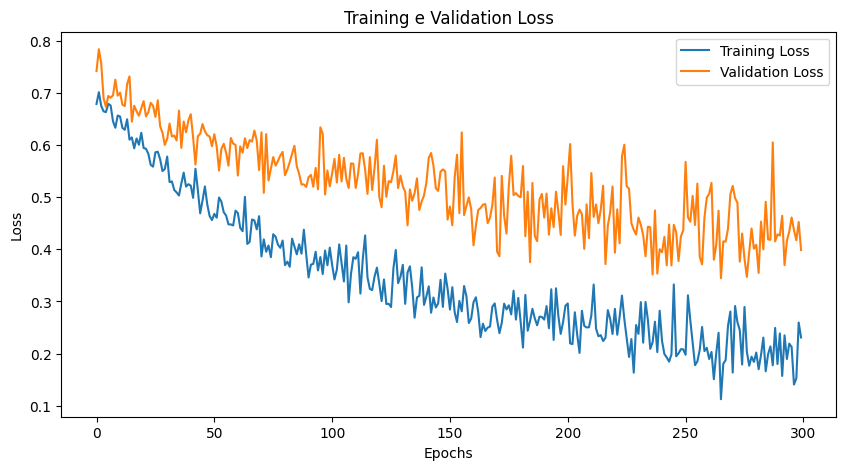

In [24]:
plot_comparison(train_losses, val_losses)

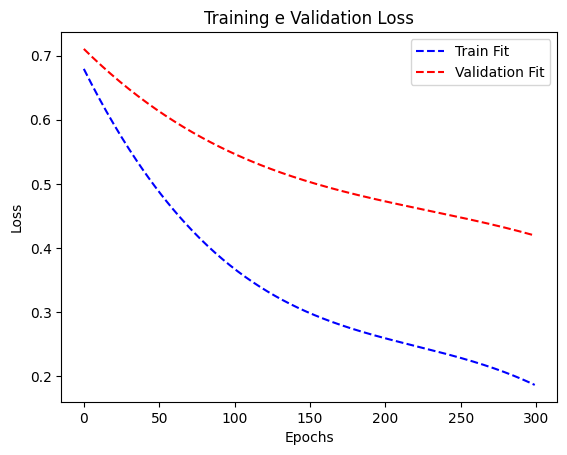

In [25]:
plot_equation(train_losses, val_losses)

In [26]:
resnet.load_state_dict(torch.load(model_save_path))
resnet.to(device)
print('')

In [27]:
preds, labels = evaluate_model(resnet, test_loader)
accuracy, conf_matrix, precision, recall, f1_score = calculate_metrics(preds, labels)

In [28]:
print_results(accuracy, conf_matrix, precision, recall, f1_score)

Acurácia: 0.6250
Matriz de Confusão:
[[4 0]
 [3 1]]
Precisão: 0.7857
Recall: 0.6250
F1 Score: 0.5636


 ## Modelo 2 - VGG

In [29]:
vgg = torchvision.models.vgg16(pretrained=True)

C:\Users\Cliente\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Cliente\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [30]:
vgg.classifier[6] = nn.Linear(4096, 2)

In [31]:
for name, params in vgg.named_parameters():
    if name not in ('classifier.6.weight', 'classifier.6.bias'):
        params.requires_grad = False

In [32]:
vgg.to(device)
optimizer = optim.Adam(vgg.parameters(), lr=0.0001)
model_save_path = 'top_vgg'

In [33]:
train_losses, val_losses = train(vgg, train_loader, val_loader, optimizer, criterion, epochs, early_stop_patience, model_save_path)

Epoch 1/300: 100%|███████████████████████████████████████████████████████████████████████| 7/7 [00:08<00:00,  1.27s/it]


Epoch: 1 | Train Loss: 0.7700 | Val Loss: 0.6395


Epoch 2/300: 100%|███████████████████████████████████████████████████████████████████████| 7/7 [00:08<00:00,  1.29s/it]


Epoch: 2 | Train Loss: 0.6189 | Val Loss: 0.6700


Epoch 3/300: 100%|███████████████████████████████████████████████████████████████████████| 7/7 [00:08<00:00,  1.28s/it]


Epoch: 3 | Train Loss: 0.6868 | Val Loss: 0.4931


Epoch 4/300: 100%|███████████████████████████████████████████████████████████████████████| 7/7 [00:09<00:00,  1.37s/it]


Epoch: 4 | Train Loss: 0.5268 | Val Loss: 0.5889


Epoch 5/300: 100%|███████████████████████████████████████████████████████████████████████| 7/7 [00:08<00:00,  1.24s/it]


Epoch: 5 | Train Loss: 0.5199 | Val Loss: 0.5958


Epoch 6/300: 100%|███████████████████████████████████████████████████████████████████████| 7/7 [00:08<00:00,  1.22s/it]


Epoch: 6 | Train Loss: 0.5531 | Val Loss: 0.4999


Epoch 7/300: 100%|███████████████████████████████████████████████████████████████████████| 7/7 [00:08<00:00,  1.20s/it]


Epoch: 7 | Train Loss: 0.4553 | Val Loss: 0.5738


Epoch 8/300: 100%|███████████████████████████████████████████████████████████████████████| 7/7 [00:09<00:00,  1.29s/it]


Epoch: 8 | Train Loss: 0.5505 | Val Loss: 0.4707


Epoch 9/300: 100%|███████████████████████████████████████████████████████████████████████| 7/7 [00:09<00:00,  1.30s/it]


Epoch: 9 | Train Loss: 0.4573 | Val Loss: 0.4821


Epoch 10/300: 100%|██████████████████████████████████████████████████████████████████████| 7/7 [00:09<00:00,  1.33s/it]


Epoch: 10 | Train Loss: 0.4664 | Val Loss: 0.4831


Epoch 11/300: 100%|██████████████████████████████████████████████████████████████████████| 7/7 [00:09<00:00,  1.35s/it]


Epoch: 11 | Train Loss: 0.4046 | Val Loss: 0.4487


Epoch 12/300: 100%|██████████████████████████████████████████████████████████████████████| 7/7 [00:08<00:00,  1.25s/it]


Epoch: 12 | Train Loss: 0.3758 | Val Loss: 0.4930


Epoch 13/300: 100%|██████████████████████████████████████████████████████████████████████| 7/7 [00:08<00:00,  1.24s/it]


Epoch: 13 | Train Loss: 0.3542 | Val Loss: 0.4706


Epoch 14/300: 100%|██████████████████████████████████████████████████████████████████████| 7/7 [00:08<00:00,  1.25s/it]


Epoch: 14 | Train Loss: 0.4124 | Val Loss: 0.4868


Epoch 15/300: 100%|██████████████████████████████████████████████████████████████████████| 7/7 [00:08<00:00,  1.22s/it]


Epoch: 15 | Train Loss: 0.4006 | Val Loss: 0.3768


Epoch 16/300: 100%|██████████████████████████████████████████████████████████████████████| 7/7 [00:09<00:00,  1.29s/it]


Epoch: 16 | Train Loss: 0.2701 | Val Loss: 0.3759


Epoch 17/300: 100%|██████████████████████████████████████████████████████████████████████| 7/7 [00:09<00:00,  1.30s/it]


Epoch: 17 | Train Loss: 0.3736 | Val Loss: 0.4435


Epoch 18/300: 100%|██████████████████████████████████████████████████████████████████████| 7/7 [00:08<00:00,  1.28s/it]


Epoch: 18 | Train Loss: 0.3315 | Val Loss: 0.4392


Epoch 19/300: 100%|██████████████████████████████████████████████████████████████████████| 7/7 [00:09<00:00,  1.29s/it]


Epoch: 19 | Train Loss: 0.2823 | Val Loss: 0.6265


Epoch 20/300: 100%|██████████████████████████████████████████████████████████████████████| 7/7 [00:08<00:00,  1.27s/it]


Epoch: 20 | Train Loss: 0.3432 | Val Loss: 0.2911


Epoch 21/300: 100%|██████████████████████████████████████████████████████████████████████| 7/7 [00:08<00:00,  1.28s/it]


Epoch: 21 | Train Loss: 0.3313 | Val Loss: 0.5178


Epoch 22/300: 100%|██████████████████████████████████████████████████████████████████████| 7/7 [00:08<00:00,  1.20s/it]


Epoch: 22 | Train Loss: 0.3209 | Val Loss: 0.6478


Epoch 23/300: 100%|██████████████████████████████████████████████████████████████████████| 7/7 [00:08<00:00,  1.21s/it]


Epoch: 23 | Train Loss: 0.2585 | Val Loss: 0.3740


Epoch 24/300: 100%|██████████████████████████████████████████████████████████████████████| 7/7 [00:08<00:00,  1.20s/it]


Epoch: 24 | Train Loss: 0.3009 | Val Loss: 0.3791


Epoch 25/300: 100%|██████████████████████████████████████████████████████████████████████| 7/7 [00:08<00:00,  1.22s/it]


Epoch: 25 | Train Loss: 0.2882 | Val Loss: 0.3941


Epoch 26/300: 100%|██████████████████████████████████████████████████████████████████████| 7/7 [00:08<00:00,  1.25s/it]


Epoch: 26 | Train Loss: 0.2281 | Val Loss: 0.2852


Epoch 27/300: 100%|██████████████████████████████████████████████████████████████████████| 7/7 [00:09<00:00,  1.30s/it]


Epoch: 27 | Train Loss: 0.2740 | Val Loss: 0.3958


Epoch 28/300: 100%|██████████████████████████████████████████████████████████████████████| 7/7 [00:08<00:00,  1.28s/it]


Epoch: 28 | Train Loss: 0.2425 | Val Loss: 0.3564


Epoch 29/300: 100%|██████████████████████████████████████████████████████████████████████| 7/7 [00:08<00:00,  1.28s/it]


Epoch: 29 | Train Loss: 0.2054 | Val Loss: 0.5016


Epoch 30/300: 100%|██████████████████████████████████████████████████████████████████████| 7/7 [00:08<00:00,  1.24s/it]


Epoch: 30 | Train Loss: 0.2025 | Val Loss: 0.3241


Epoch 31/300: 100%|██████████████████████████████████████████████████████████████████████| 7/7 [00:08<00:00,  1.23s/it]


Epoch: 31 | Train Loss: 0.2698 | Val Loss: 0.5590


Epoch 32/300: 100%|██████████████████████████████████████████████████████████████████████| 7/7 [00:08<00:00,  1.24s/it]


Epoch: 32 | Train Loss: 0.2021 | Val Loss: 0.5144


Epoch 33/300: 100%|██████████████████████████████████████████████████████████████████████| 7/7 [00:08<00:00,  1.24s/it]


Epoch: 33 | Train Loss: 0.2456 | Val Loss: 0.3484


Epoch 34/300: 100%|██████████████████████████████████████████████████████████████████████| 7/7 [00:08<00:00,  1.24s/it]


Epoch: 34 | Train Loss: 0.1999 | Val Loss: 0.3538


Epoch 35/300: 100%|██████████████████████████████████████████████████████████████████████| 7/7 [00:08<00:00,  1.23s/it]


Epoch: 35 | Train Loss: 0.2264 | Val Loss: 0.3951


Epoch 36/300: 100%|██████████████████████████████████████████████████████████████████████| 7/7 [00:08<00:00,  1.24s/it]


Epoch: 36 | Train Loss: 0.1292 | Val Loss: 0.4816


Epoch 37/300: 100%|██████████████████████████████████████████████████████████████████████| 7/7 [00:08<00:00,  1.23s/it]


Epoch: 37 | Train Loss: 0.1837 | Val Loss: 0.4445


Epoch 38/300: 100%|██████████████████████████████████████████████████████████████████████| 7/7 [00:08<00:00,  1.28s/it]


Epoch: 38 | Train Loss: 0.1252 | Val Loss: 0.3497


Epoch 39/300: 100%|██████████████████████████████████████████████████████████████████████| 7/7 [00:08<00:00,  1.25s/it]


Epoch: 39 | Train Loss: 0.1787 | Val Loss: 0.3395


Epoch 40/300: 100%|██████████████████████████████████████████████████████████████████████| 7/7 [00:08<00:00,  1.25s/it]


Epoch: 40 | Train Loss: 0.2044 | Val Loss: 0.3735


Epoch 41/300: 100%|██████████████████████████████████████████████████████████████████████| 7/7 [00:08<00:00,  1.25s/it]


Epoch: 41 | Train Loss: 0.2137 | Val Loss: 0.5002


Epoch 42/300: 100%|██████████████████████████████████████████████████████████████████████| 7/7 [00:08<00:00,  1.27s/it]


Epoch: 42 | Train Loss: 0.2658 | Val Loss: 0.2884


Epoch 43/300: 100%|██████████████████████████████████████████████████████████████████████| 7/7 [00:08<00:00,  1.20s/it]


Epoch: 43 | Train Loss: 0.2257 | Val Loss: 0.3221


Epoch 44/300: 100%|██████████████████████████████████████████████████████████████████████| 7/7 [00:08<00:00,  1.18s/it]


Epoch: 44 | Train Loss: 0.1591 | Val Loss: 0.3490


Epoch 45/300: 100%|██████████████████████████████████████████████████████████████████████| 7/7 [00:08<00:00,  1.25s/it]


Epoch: 45 | Train Loss: 0.1467 | Val Loss: 0.3422


Epoch 46/300: 100%|██████████████████████████████████████████████████████████████████████| 7/7 [00:08<00:00,  1.26s/it]


Epoch: 46 | Train Loss: 0.2993 | Val Loss: 0.4152


Epoch 47/300: 100%|██████████████████████████████████████████████████████████████████████| 7/7 [00:08<00:00,  1.27s/it]


Epoch: 47 | Train Loss: 0.1365 | Val Loss: 0.5673


Epoch 48/300: 100%|██████████████████████████████████████████████████████████████████████| 7/7 [00:08<00:00,  1.20s/it]


Epoch: 48 | Train Loss: 0.1263 | Val Loss: 0.1979


Epoch 49/300: 100%|██████████████████████████████████████████████████████████████████████| 7/7 [00:09<00:00,  1.30s/it]


Epoch: 49 | Train Loss: 0.1340 | Val Loss: 0.3219


Epoch 50/300: 100%|██████████████████████████████████████████████████████████████████████| 7/7 [00:08<00:00,  1.26s/it]


Epoch: 50 | Train Loss: 0.2295 | Val Loss: 0.6688


Epoch 51/300: 100%|██████████████████████████████████████████████████████████████████████| 7/7 [00:09<00:00,  1.31s/it]


Epoch: 51 | Train Loss: 0.1942 | Val Loss: 0.5713


Epoch 52/300: 100%|██████████████████████████████████████████████████████████████████████| 7/7 [00:09<00:00,  1.29s/it]


Epoch: 52 | Train Loss: 0.1423 | Val Loss: 0.4381


Epoch 53/300: 100%|██████████████████████████████████████████████████████████████████████| 7/7 [00:08<00:00,  1.27s/it]


Epoch: 53 | Train Loss: 0.1817 | Val Loss: 0.3511


Epoch 54/300: 100%|██████████████████████████████████████████████████████████████████████| 7/7 [00:08<00:00,  1.28s/it]


Epoch: 54 | Train Loss: 0.2292 | Val Loss: 0.4894


Epoch 55/300: 100%|██████████████████████████████████████████████████████████████████████| 7/7 [00:09<00:00,  1.30s/it]


Epoch: 55 | Train Loss: 0.1294 | Val Loss: 0.4210


Epoch 56/300: 100%|██████████████████████████████████████████████████████████████████████| 7/7 [00:08<00:00,  1.27s/it]


Epoch: 56 | Train Loss: 0.1322 | Val Loss: 0.4913


Epoch 57/300: 100%|██████████████████████████████████████████████████████████████████████| 7/7 [00:08<00:00,  1.27s/it]


Epoch: 57 | Train Loss: 0.1338 | Val Loss: 0.3823


Epoch 58/300: 100%|██████████████████████████████████████████████████████████████████████| 7/7 [00:08<00:00,  1.27s/it]


Epoch: 58 | Train Loss: 0.1604 | Val Loss: 0.5570


Epoch 59/300: 100%|██████████████████████████████████████████████████████████████████████| 7/7 [00:09<00:00,  1.30s/it]


Epoch: 59 | Train Loss: 0.1351 | Val Loss: 0.3034


Epoch 60/300: 100%|██████████████████████████████████████████████████████████████████████| 7/7 [00:09<00:00,  1.29s/it]


Epoch: 60 | Train Loss: 0.1063 | Val Loss: 0.4548


Epoch 61/300: 100%|██████████████████████████████████████████████████████████████████████| 7/7 [00:09<00:00,  1.32s/it]


Epoch: 61 | Train Loss: 0.1632 | Val Loss: 0.6007


Epoch 62/300: 100%|██████████████████████████████████████████████████████████████████████| 7/7 [00:09<00:00,  1.31s/it]


Epoch: 62 | Train Loss: 0.1382 | Val Loss: 0.4067


Epoch 63/300: 100%|██████████████████████████████████████████████████████████████████████| 7/7 [00:09<00:00,  1.31s/it]


Epoch: 63 | Train Loss: 0.1121 | Val Loss: 0.1866


Epoch 64/300: 100%|██████████████████████████████████████████████████████████████████████| 7/7 [00:08<00:00,  1.21s/it]


Epoch: 64 | Train Loss: 0.1120 | Val Loss: 0.2676


Epoch 65/300: 100%|██████████████████████████████████████████████████████████████████████| 7/7 [00:08<00:00,  1.17s/it]


Epoch: 65 | Train Loss: 0.1476 | Val Loss: 0.3535


Epoch 66/300: 100%|██████████████████████████████████████████████████████████████████████| 7/7 [00:08<00:00,  1.21s/it]


Epoch: 66 | Train Loss: 0.1977 | Val Loss: 0.3213


Epoch 67/300: 100%|██████████████████████████████████████████████████████████████████████| 7/7 [00:08<00:00,  1.22s/it]


Epoch: 67 | Train Loss: 0.1178 | Val Loss: 0.5767


Epoch 68/300: 100%|██████████████████████████████████████████████████████████████████████| 7/7 [00:08<00:00,  1.24s/it]


Epoch: 68 | Train Loss: 0.1306 | Val Loss: 0.3441


Epoch 69/300: 100%|██████████████████████████████████████████████████████████████████████| 7/7 [00:08<00:00,  1.29s/it]


Epoch: 69 | Train Loss: 0.1403 | Val Loss: 0.2372


Epoch 70/300: 100%|██████████████████████████████████████████████████████████████████████| 7/7 [00:08<00:00,  1.23s/it]


Epoch: 70 | Train Loss: 0.0721 | Val Loss: 0.3303


Epoch 71/300: 100%|██████████████████████████████████████████████████████████████████████| 7/7 [00:08<00:00,  1.22s/it]


Epoch: 71 | Train Loss: 0.1402 | Val Loss: 0.7173


Epoch 72/300: 100%|██████████████████████████████████████████████████████████████████████| 7/7 [00:08<00:00,  1.28s/it]


Epoch: 72 | Train Loss: 0.1058 | Val Loss: 0.8148


Epoch 73/300: 100%|██████████████████████████████████████████████████████████████████████| 7/7 [00:08<00:00,  1.22s/it]


Epoch: 73 | Train Loss: 0.0899 | Val Loss: 0.3958


Epoch 74/300: 100%|██████████████████████████████████████████████████████████████████████| 7/7 [00:08<00:00,  1.24s/it]


Epoch: 74 | Train Loss: 0.1378 | Val Loss: 0.3046


Epoch 75/300: 100%|██████████████████████████████████████████████████████████████████████| 7/7 [00:08<00:00,  1.24s/it]


Epoch: 75 | Train Loss: 0.0925 | Val Loss: 0.3272


Epoch 76/300: 100%|██████████████████████████████████████████████████████████████████████| 7/7 [00:08<00:00,  1.21s/it]


Epoch: 76 | Train Loss: 0.1063 | Val Loss: 0.5933


Epoch 77/300: 100%|██████████████████████████████████████████████████████████████████████| 7/7 [00:08<00:00,  1.25s/it]


Epoch: 77 | Train Loss: 0.1209 | Val Loss: 0.4873


Epoch 78/300: 100%|██████████████████████████████████████████████████████████████████████| 7/7 [00:08<00:00,  1.23s/it]


Epoch: 78 | Train Loss: 0.0961 | Val Loss: 0.4023


Epoch 79/300: 100%|██████████████████████████████████████████████████████████████████████| 7/7 [00:08<00:00,  1.24s/it]


Epoch: 79 | Train Loss: 0.1074 | Val Loss: 0.1462


Epoch 80/300: 100%|██████████████████████████████████████████████████████████████████████| 7/7 [00:09<00:00,  1.30s/it]


Epoch: 80 | Train Loss: 0.1498 | Val Loss: 0.2509


Epoch 81/300: 100%|██████████████████████████████████████████████████████████████████████| 7/7 [00:09<00:00,  1.32s/it]


Epoch: 81 | Train Loss: 0.0785 | Val Loss: 0.3086


Epoch 82/300: 100%|██████████████████████████████████████████████████████████████████████| 7/7 [00:08<00:00,  1.28s/it]


Epoch: 82 | Train Loss: 0.1152 | Val Loss: 0.5001


Epoch 83/300: 100%|██████████████████████████████████████████████████████████████████████| 7/7 [00:08<00:00,  1.28s/it]


Epoch: 83 | Train Loss: 0.1075 | Val Loss: 0.1523


Epoch 84/300: 100%|██████████████████████████████████████████████████████████████████████| 7/7 [00:08<00:00,  1.28s/it]


Epoch: 84 | Train Loss: 0.0900 | Val Loss: 0.3772


Epoch 85/300: 100%|██████████████████████████████████████████████████████████████████████| 7/7 [00:09<00:00,  1.29s/it]


Epoch: 85 | Train Loss: 0.1092 | Val Loss: 0.5280


Epoch 86/300: 100%|██████████████████████████████████████████████████████████████████████| 7/7 [00:08<00:00,  1.26s/it]


Epoch: 86 | Train Loss: 0.1468 | Val Loss: 0.3674


Epoch 87/300: 100%|██████████████████████████████████████████████████████████████████████| 7/7 [00:09<00:00,  1.33s/it]


Epoch: 87 | Train Loss: 0.0976 | Val Loss: 0.4241


Epoch 88/300: 100%|██████████████████████████████████████████████████████████████████████| 7/7 [00:08<00:00,  1.22s/it]


Epoch: 88 | Train Loss: 0.1233 | Val Loss: 0.3175


Epoch 89/300: 100%|██████████████████████████████████████████████████████████████████████| 7/7 [00:08<00:00,  1.25s/it]


Epoch: 89 | Train Loss: 0.0751 | Val Loss: 0.3129


Epoch 90/300: 100%|██████████████████████████████████████████████████████████████████████| 7/7 [00:08<00:00,  1.23s/it]


Epoch: 90 | Train Loss: 0.0602 | Val Loss: 0.4602


Epoch 91/300: 100%|██████████████████████████████████████████████████████████████████████| 7/7 [00:08<00:00,  1.23s/it]


Epoch: 91 | Train Loss: 0.0888 | Val Loss: 0.6643


Epoch 92/300: 100%|██████████████████████████████████████████████████████████████████████| 7/7 [00:08<00:00,  1.24s/it]


Epoch: 92 | Train Loss: 0.1188 | Val Loss: 0.4299


Epoch 93/300: 100%|██████████████████████████████████████████████████████████████████████| 7/7 [00:08<00:00,  1.26s/it]


Epoch: 93 | Train Loss: 0.1264 | Val Loss: 0.2815


Epoch 94/300: 100%|██████████████████████████████████████████████████████████████████████| 7/7 [00:08<00:00,  1.24s/it]


Epoch: 94 | Train Loss: 0.0926 | Val Loss: 0.3435


Epoch 95/300: 100%|██████████████████████████████████████████████████████████████████████| 7/7 [00:08<00:00,  1.23s/it]


Epoch: 95 | Train Loss: 0.0870 | Val Loss: 0.3287


Epoch 96/300: 100%|██████████████████████████████████████████████████████████████████████| 7/7 [00:08<00:00,  1.24s/it]


Epoch: 96 | Train Loss: 0.1217 | Val Loss: 0.4071


Epoch 97/300: 100%|██████████████████████████████████████████████████████████████████████| 7/7 [00:08<00:00,  1.28s/it]


Epoch: 97 | Train Loss: 0.0869 | Val Loss: 0.2458


Epoch 98/300: 100%|██████████████████████████████████████████████████████████████████████| 7/7 [00:09<00:00,  1.29s/it]


Epoch: 98 | Train Loss: 0.0602 | Val Loss: 0.4554


Epoch 99/300: 100%|██████████████████████████████████████████████████████████████████████| 7/7 [00:08<00:00,  1.25s/it]


Epoch: 99 | Train Loss: 0.1142 | Val Loss: 0.4391


Epoch 100/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:09<00:00,  1.30s/it]


Epoch: 100 | Train Loss: 0.0900 | Val Loss: 0.2818


Epoch 101/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:09<00:00,  1.34s/it]


Epoch: 101 | Train Loss: 0.0955 | Val Loss: 0.4121


Epoch 102/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:08<00:00,  1.26s/it]


Epoch: 102 | Train Loss: 0.0791 | Val Loss: 0.5366


Epoch 103/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:08<00:00,  1.25s/it]


Epoch: 103 | Train Loss: 0.1297 | Val Loss: 0.2839


Epoch 104/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:09<00:00,  1.35s/it]


Epoch: 104 | Train Loss: 0.0798 | Val Loss: 0.3380


Epoch 105/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]


Epoch: 105 | Train Loss: 0.1076 | Val Loss: 0.2134


Epoch 106/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.46s/it]


Epoch: 106 | Train Loss: 0.2169 | Val Loss: 0.2378


Epoch 107/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:09<00:00,  1.32s/it]


Epoch: 107 | Train Loss: 0.1530 | Val Loss: 0.4082


Epoch 108/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:09<00:00,  1.29s/it]


Epoch: 108 | Train Loss: 0.0903 | Val Loss: 0.2119


Epoch 109/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:09<00:00,  1.32s/it]


Epoch: 109 | Train Loss: 0.0604 | Val Loss: 0.2585


Epoch 110/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:09<00:00,  1.36s/it]


Epoch: 110 | Train Loss: 0.0998 | Val Loss: 0.2338


Epoch 111/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:09<00:00,  1.30s/it]


Epoch: 111 | Train Loss: 0.0777 | Val Loss: 0.1885


Epoch 112/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:09<00:00,  1.33s/it]


Epoch: 112 | Train Loss: 0.0790 | Val Loss: 0.3961


Epoch 113/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:08<00:00,  1.24s/it]


Epoch: 113 | Train Loss: 0.0762 | Val Loss: 0.1743


Epoch 114/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:08<00:00,  1.27s/it]


Epoch: 114 | Train Loss: 0.0825 | Val Loss: 0.2411


Epoch 115/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:08<00:00,  1.28s/it]


Epoch: 115 | Train Loss: 0.1183 | Val Loss: 0.2094


Epoch 116/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:08<00:00,  1.25s/it]


Epoch: 116 | Train Loss: 0.0632 | Val Loss: 0.4361


Epoch 117/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:08<00:00,  1.26s/it]


Epoch: 117 | Train Loss: 0.1023 | Val Loss: 0.4001


Epoch 118/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:09<00:00,  1.30s/it]


Epoch: 118 | Train Loss: 0.0751 | Val Loss: 0.2388


Epoch 119/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:08<00:00,  1.28s/it]


Epoch: 119 | Train Loss: 0.0934 | Val Loss: 0.5940


Epoch 120/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:08<00:00,  1.27s/it]


Epoch: 120 | Train Loss: 0.0580 | Val Loss: 0.3988


Epoch 121/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:08<00:00,  1.27s/it]


Epoch: 121 | Train Loss: 0.0403 | Val Loss: 0.3749


Epoch 122/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:08<00:00,  1.28s/it]


Epoch: 122 | Train Loss: 0.1434 | Val Loss: 0.5305


Epoch 123/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:08<00:00,  1.26s/it]


Epoch: 123 | Train Loss: 0.0577 | Val Loss: 0.4655


Epoch 124/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:09<00:00,  1.33s/it]


Epoch: 124 | Train Loss: 0.0615 | Val Loss: 0.5116


Epoch 125/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:09<00:00,  1.33s/it]


Epoch: 125 | Train Loss: 0.0530 | Val Loss: 0.2758


Epoch 126/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:09<00:00,  1.31s/it]


Epoch: 126 | Train Loss: 0.0660 | Val Loss: 0.1906


Epoch 127/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:09<00:00,  1.30s/it]


Epoch: 127 | Train Loss: 0.0833 | Val Loss: 0.3527


Epoch 128/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:09<00:00,  1.35s/it]


Epoch: 128 | Train Loss: 0.0878 | Val Loss: 0.2258


Epoch 129/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:09<00:00,  1.30s/it]


Epoch: 129 | Train Loss: 0.0599 | Val Loss: 0.3403


Epoch 130/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:08<00:00,  1.28s/it]


Epoch: 130 | Train Loss: 0.0695 | Val Loss: 0.1309


Epoch 131/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:09<00:00,  1.31s/it]


Epoch: 131 | Train Loss: 0.0465 | Val Loss: 0.3823


Epoch 132/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:09<00:00,  1.30s/it]


Epoch: 132 | Train Loss: 0.0605 | Val Loss: 0.6062


Epoch 133/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:09<00:00,  1.31s/it]


Epoch: 133 | Train Loss: 0.0885 | Val Loss: 0.2246


Epoch 134/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:08<00:00,  1.28s/it]


Epoch: 134 | Train Loss: 0.0433 | Val Loss: 0.2527


Epoch 135/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:08<00:00,  1.25s/it]


Epoch: 135 | Train Loss: 0.0689 | Val Loss: 0.1661


Epoch 136/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:08<00:00,  1.24s/it]


Epoch: 136 | Train Loss: 0.0651 | Val Loss: 0.2494


Epoch 137/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:08<00:00,  1.20s/it]


Epoch: 137 | Train Loss: 0.0884 | Val Loss: 0.4283


Epoch 138/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:08<00:00,  1.20s/it]


Epoch: 138 | Train Loss: 0.0657 | Val Loss: 0.0901


Epoch 139/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:09<00:00,  1.31s/it]


Epoch: 139 | Train Loss: 0.0772 | Val Loss: 0.4086


Epoch 140/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:09<00:00,  1.31s/it]


Epoch: 140 | Train Loss: 0.0439 | Val Loss: 0.2631


Epoch 141/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:09<00:00,  1.30s/it]


Epoch: 141 | Train Loss: 0.0600 | Val Loss: 0.1201


Epoch 142/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:08<00:00,  1.28s/it]


Epoch: 142 | Train Loss: 0.0785 | Val Loss: 0.3079


Epoch 143/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:09<00:00,  1.32s/it]


Epoch: 143 | Train Loss: 0.0562 | Val Loss: 0.5034


Epoch 144/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:09<00:00,  1.32s/it]


Epoch: 144 | Train Loss: 0.0752 | Val Loss: 0.5436


Epoch 145/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:08<00:00,  1.28s/it]


Epoch: 145 | Train Loss: 0.0362 | Val Loss: 0.4135


Epoch 146/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:08<00:00,  1.27s/it]


Epoch: 146 | Train Loss: 0.0764 | Val Loss: 0.3904


Epoch 147/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:09<00:00,  1.31s/it]


Epoch: 147 | Train Loss: 0.0612 | Val Loss: 0.7027


Epoch 148/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:09<00:00,  1.30s/it]


Epoch: 148 | Train Loss: 0.0862 | Val Loss: 0.3610


Epoch 149/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:08<00:00,  1.26s/it]


Epoch: 149 | Train Loss: 0.0455 | Val Loss: 0.2385


Epoch 150/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:08<00:00,  1.28s/it]


Epoch: 150 | Train Loss: 0.0541 | Val Loss: 0.3154


Epoch 151/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:08<00:00,  1.27s/it]


Epoch: 151 | Train Loss: 0.0611 | Val Loss: 0.2379


Epoch 152/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:08<00:00,  1.28s/it]


Epoch: 152 | Train Loss: 0.0442 | Val Loss: 0.1392


Epoch 153/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:09<00:00,  1.29s/it]


Epoch: 153 | Train Loss: 0.1368 | Val Loss: 0.2238


Epoch 154/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:08<00:00,  1.26s/it]


Epoch: 154 | Train Loss: 0.0811 | Val Loss: 0.2326


Epoch 155/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:08<00:00,  1.27s/it]


Epoch: 155 | Train Loss: 0.0921 | Val Loss: 0.1640


Epoch 156/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:09<00:00,  1.32s/it]


Epoch: 156 | Train Loss: 0.0302 | Val Loss: 0.1171


Epoch 157/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:08<00:00,  1.26s/it]


Epoch: 157 | Train Loss: 0.0734 | Val Loss: 0.2162


Epoch 158/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:08<00:00,  1.28s/it]


Epoch: 158 | Train Loss: 0.1076 | Val Loss: 0.2987


Epoch 159/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:08<00:00,  1.25s/it]


Epoch: 159 | Train Loss: 0.0536 | Val Loss: 0.5953


Epoch 160/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:09<00:00,  1.31s/it]


Epoch: 160 | Train Loss: 0.0674 | Val Loss: 0.4567


Epoch 161/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:09<00:00,  1.36s/it]


Epoch: 161 | Train Loss: 0.0964 | Val Loss: 0.4370


Epoch 162/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:09<00:00,  1.34s/it]


Epoch: 162 | Train Loss: 0.0822 | Val Loss: 0.2045


Epoch 163/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:09<00:00,  1.29s/it]


Epoch: 163 | Train Loss: 0.0443 | Val Loss: 0.2197


Epoch 164/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:09<00:00,  1.31s/it]


Epoch: 164 | Train Loss: 0.0859 | Val Loss: 0.2941


Epoch 165/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:08<00:00,  1.26s/it]


Epoch: 165 | Train Loss: 0.1026 | Val Loss: 0.6904


Epoch 166/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:09<00:00,  1.32s/it]


Epoch: 166 | Train Loss: 0.0578 | Val Loss: 0.2869


Epoch 167/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:09<00:00,  1.29s/it]


Epoch: 167 | Train Loss: 0.0464 | Val Loss: 0.2483


Epoch 168/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:08<00:00,  1.27s/it]


Epoch: 168 | Train Loss: 0.0745 | Val Loss: 0.3811


Epoch 169/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:08<00:00,  1.28s/it]


Epoch: 169 | Train Loss: 0.0445 | Val Loss: 0.3267


Epoch 170/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:09<00:00,  1.30s/it]


Epoch: 170 | Train Loss: 0.1043 | Val Loss: 0.1505


Epoch 171/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:09<00:00,  1.29s/it]


Epoch: 171 | Train Loss: 0.0365 | Val Loss: 0.2041


Epoch 172/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:08<00:00,  1.26s/it]


Epoch: 172 | Train Loss: 0.0840 | Val Loss: 0.6056


Epoch 173/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:08<00:00,  1.25s/it]


Epoch: 173 | Train Loss: 0.0624 | Val Loss: 0.2871


Epoch 174/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:08<00:00,  1.23s/it]


Epoch: 174 | Train Loss: 0.0460 | Val Loss: 0.6239


Epoch 175/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:09<00:00,  1.29s/it]


Epoch: 175 | Train Loss: 0.0373 | Val Loss: 0.2326


Epoch 176/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:08<00:00,  1.23s/it]


Epoch: 176 | Train Loss: 0.0461 | Val Loss: 0.3495


Epoch 177/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:09<00:00,  1.29s/it]


Epoch: 177 | Train Loss: 0.0519 | Val Loss: 0.2215


Epoch 178/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:09<00:00,  1.31s/it]


Epoch: 178 | Train Loss: 0.0606 | Val Loss: 0.5974


Epoch 179/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:08<00:00,  1.23s/it]


Epoch: 179 | Train Loss: 0.0266 | Val Loss: 0.1928


Epoch 180/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:09<00:00,  1.37s/it]


Epoch: 180 | Train Loss: 0.0348 | Val Loss: 0.4882


Epoch 181/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:09<00:00,  1.35s/it]


Epoch: 181 | Train Loss: 0.0517 | Val Loss: 0.3219


Epoch 182/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:09<00:00,  1.36s/it]


Epoch: 182 | Train Loss: 0.0488 | Val Loss: 0.2453


Epoch 183/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:09<00:00,  1.38s/it]


Epoch: 183 | Train Loss: 0.1043 | Val Loss: 0.2203


Epoch 184/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:09<00:00,  1.37s/it]


Epoch: 184 | Train Loss: 0.0358 | Val Loss: 0.1626


Epoch 185/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:09<00:00,  1.36s/it]


Epoch: 185 | Train Loss: 0.0372 | Val Loss: 0.3012


Epoch 186/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:09<00:00,  1.34s/it]


Epoch: 186 | Train Loss: 0.0557 | Val Loss: 0.3097


Epoch 187/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:09<00:00,  1.35s/it]


Epoch: 187 | Train Loss: 0.0589 | Val Loss: 0.4185


Epoch 188/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:08<00:00,  1.27s/it]


Epoch: 188 | Train Loss: 0.0400 | Val Loss: 0.2873


Epoch 189/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:08<00:00,  1.27s/it]


Epoch: 189 | Train Loss: 0.1112 | Val Loss: 0.2869


Epoch 190/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:09<00:00,  1.37s/it]


Epoch: 190 | Train Loss: 0.0416 | Val Loss: 0.2516


Epoch 191/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:09<00:00,  1.31s/it]


Epoch: 191 | Train Loss: 0.0579 | Val Loss: 0.8866


Epoch 192/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:09<00:00,  1.34s/it]


Epoch: 192 | Train Loss: 0.1002 | Val Loss: 0.3668


Epoch 193/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:09<00:00,  1.34s/it]


Epoch: 193 | Train Loss: 0.0484 | Val Loss: 0.3129


Epoch 194/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:08<00:00,  1.28s/it]


Epoch: 194 | Train Loss: 0.1113 | Val Loss: 0.6827


Epoch 195/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:08<00:00,  1.25s/it]


Epoch: 195 | Train Loss: 0.0692 | Val Loss: 0.1157


Epoch 196/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:09<00:00,  1.37s/it]


Epoch: 196 | Train Loss: 0.0795 | Val Loss: 0.0747


Epoch 197/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:09<00:00,  1.34s/it]


Epoch: 197 | Train Loss: 0.0537 | Val Loss: 0.2100


Epoch 198/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:08<00:00,  1.27s/it]


Epoch: 198 | Train Loss: 0.0327 | Val Loss: 0.1519


Epoch 199/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:09<00:00,  1.32s/it]


Epoch: 199 | Train Loss: 0.0251 | Val Loss: 0.3176


Epoch 200/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:08<00:00,  1.26s/it]


Epoch: 200 | Train Loss: 0.0424 | Val Loss: 0.1087


Epoch 201/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:08<00:00,  1.23s/it]


Epoch: 201 | Train Loss: 0.0284 | Val Loss: 0.1148


Epoch 202/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:09<00:00,  1.33s/it]


Epoch: 202 | Train Loss: 0.0285 | Val Loss: 0.2263


Epoch 203/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:08<00:00,  1.28s/it]


Epoch: 203 | Train Loss: 0.0601 | Val Loss: 0.3829


Epoch 204/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:09<00:00,  1.30s/it]


Epoch: 204 | Train Loss: 0.0580 | Val Loss: 0.3134


Epoch 205/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:09<00:00,  1.32s/it]


Epoch: 205 | Train Loss: 0.0204 | Val Loss: 0.2846


Epoch 206/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:08<00:00,  1.27s/it]


Epoch: 206 | Train Loss: 0.0376 | Val Loss: 0.3859


Epoch 207/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:08<00:00,  1.20s/it]


Epoch: 207 | Train Loss: 0.0513 | Val Loss: 0.5247


Epoch 208/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:08<00:00,  1.25s/it]


Epoch: 208 | Train Loss: 0.0411 | Val Loss: 0.4224


Epoch 209/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:09<00:00,  1.31s/it]


Epoch: 209 | Train Loss: 0.1472 | Val Loss: 0.2505


Epoch 210/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:08<00:00,  1.27s/it]


Epoch: 210 | Train Loss: 0.0620 | Val Loss: 0.2131


Epoch 211/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:09<00:00,  1.33s/it]


Epoch: 211 | Train Loss: 0.0567 | Val Loss: 0.2134


Epoch 212/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:09<00:00,  1.37s/it]


Epoch: 212 | Train Loss: 0.0234 | Val Loss: 0.4181


Epoch 213/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:09<00:00,  1.31s/it]


Epoch: 213 | Train Loss: 0.0347 | Val Loss: 0.1671


Epoch 214/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:09<00:00,  1.32s/it]


Epoch: 214 | Train Loss: 0.1112 | Val Loss: 0.2612


Epoch 215/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:08<00:00,  1.26s/it]


Epoch: 215 | Train Loss: 0.0317 | Val Loss: 0.2706


Epoch 216/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:09<00:00,  1.36s/it]


Epoch: 216 | Train Loss: 0.0721 | Val Loss: 0.1462


Epoch 217/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:09<00:00,  1.29s/it]


Epoch: 217 | Train Loss: 0.0384 | Val Loss: 0.1798


Epoch 218/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:09<00:00,  1.29s/it]


Epoch: 218 | Train Loss: 0.0250 | Val Loss: 0.2200


Epoch 219/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:09<00:00,  1.30s/it]


Epoch: 219 | Train Loss: 0.0402 | Val Loss: 0.4930


Epoch 220/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:08<00:00,  1.25s/it]


Epoch: 220 | Train Loss: 0.0898 | Val Loss: 0.2011


Epoch 221/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:09<00:00,  1.34s/it]


Epoch: 221 | Train Loss: 0.0712 | Val Loss: 0.4722


Epoch 222/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:08<00:00,  1.27s/it]


Epoch: 222 | Train Loss: 0.0354 | Val Loss: 0.2463


Epoch 223/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:09<00:00,  1.35s/it]


Epoch: 223 | Train Loss: 0.0473 | Val Loss: 0.1270


Epoch 224/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:08<00:00,  1.27s/it]


Epoch: 224 | Train Loss: 0.0454 | Val Loss: 0.5908


Epoch 225/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:08<00:00,  1.25s/it]


Epoch: 225 | Train Loss: 0.0452 | Val Loss: 0.3406


Epoch 226/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:09<00:00,  1.30s/it]


Epoch: 226 | Train Loss: 0.0396 | Val Loss: 0.5028


Epoch 227/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:09<00:00,  1.30s/it]


Epoch: 227 | Train Loss: 0.0372 | Val Loss: 0.2405


Epoch 228/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:08<00:00,  1.22s/it]


Epoch: 228 | Train Loss: 0.0613 | Val Loss: 0.1686


Epoch 229/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:09<00:00,  1.31s/it]


Epoch: 229 | Train Loss: 0.0307 | Val Loss: 0.1398


Epoch 230/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:09<00:00,  1.29s/it]


Epoch: 230 | Train Loss: 0.0808 | Val Loss: 0.2365


Epoch 231/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:09<00:00,  1.31s/it]


Epoch: 231 | Train Loss: 0.0420 | Val Loss: 0.2647


Epoch 232/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:08<00:00,  1.27s/it]


Epoch: 232 | Train Loss: 0.0402 | Val Loss: 0.3083


Epoch 233/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:08<00:00,  1.27s/it]


Epoch: 233 | Train Loss: 0.0866 | Val Loss: 0.1734


Epoch 234/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:09<00:00,  1.34s/it]


Epoch: 234 | Train Loss: 0.0461 | Val Loss: 0.3859


Epoch 235/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:09<00:00,  1.33s/it]


Epoch: 235 | Train Loss: 0.0408 | Val Loss: 0.2432


Epoch 236/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:08<00:00,  1.27s/it]


Epoch: 236 | Train Loss: 0.0227 | Val Loss: 0.1815


Epoch 237/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:08<00:00,  1.27s/it]


Epoch: 237 | Train Loss: 0.0331 | Val Loss: 0.5043


Epoch 238/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:08<00:00,  1.27s/it]


Epoch: 238 | Train Loss: 0.0387 | Val Loss: 0.3596


Epoch 239/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:09<00:00,  1.31s/it]


Epoch: 239 | Train Loss: 0.0400 | Val Loss: 0.2609


Epoch 240/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:08<00:00,  1.28s/it]


Epoch: 240 | Train Loss: 0.0548 | Val Loss: 0.3133


Epoch 241/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:08<00:00,  1.24s/it]


Epoch: 241 | Train Loss: 0.0364 | Val Loss: 0.2285


Epoch 242/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:08<00:00,  1.28s/it]


Epoch: 242 | Train Loss: 0.0449 | Val Loss: 0.3745


Epoch 243/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:09<00:00,  1.32s/it]


Epoch: 243 | Train Loss: 0.0426 | Val Loss: 0.3028


Epoch 244/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:08<00:00,  1.26s/it]


Epoch: 244 | Train Loss: 0.0560 | Val Loss: 0.2436


Epoch 245/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:08<00:00,  1.26s/it]


Epoch: 245 | Train Loss: 0.0343 | Val Loss: 0.2529


Epoch 246/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:08<00:00,  1.22s/it]


Epoch: 246 | Train Loss: 0.0468 | Val Loss: 0.2503


Epoch 247/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:08<00:00,  1.26s/it]


Epoch: 247 | Train Loss: 0.0752 | Val Loss: 0.5396


Epoch 248/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:08<00:00,  1.27s/it]


Epoch: 248 | Train Loss: 0.0594 | Val Loss: 0.1144


Epoch 249/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:08<00:00,  1.22s/it]


Epoch: 249 | Train Loss: 0.0375 | Val Loss: 0.1309


Epoch 250/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:09<00:00,  1.30s/it]


Epoch: 250 | Train Loss: 0.0357 | Val Loss: 0.2210


Epoch 251/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:09<00:00,  1.36s/it]


Epoch: 251 | Train Loss: 0.0384 | Val Loss: 0.3153


Epoch 252/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:08<00:00,  1.28s/it]


Epoch: 252 | Train Loss: 0.0229 | Val Loss: 0.2606


Epoch 253/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:08<00:00,  1.24s/it]


Epoch: 253 | Train Loss: 0.0794 | Val Loss: 0.1502


Epoch 254/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:09<00:00,  1.33s/it]


Epoch: 254 | Train Loss: 0.0217 | Val Loss: 0.2306


Epoch 255/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:08<00:00,  1.24s/it]


Epoch: 255 | Train Loss: 0.0637 | Val Loss: 0.1864


Epoch 256/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:08<00:00,  1.22s/it]


Epoch: 256 | Train Loss: 0.0463 | Val Loss: 0.4111


Epoch 257/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:08<00:00,  1.23s/it]


Epoch: 257 | Train Loss: 0.0495 | Val Loss: 0.1565


Epoch 258/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:08<00:00,  1.21s/it]


Epoch: 258 | Train Loss: 0.0851 | Val Loss: 0.0953


Epoch 259/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:09<00:00,  1.34s/it]


Epoch: 259 | Train Loss: 0.0204 | Val Loss: 0.2611


Epoch 260/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:08<00:00,  1.28s/it]


Epoch: 260 | Train Loss: 0.0283 | Val Loss: 0.3298


Epoch 261/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:09<00:00,  1.32s/it]


Epoch: 261 | Train Loss: 0.0749 | Val Loss: 0.0455


Epoch 262/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:09<00:00,  1.32s/it]


Epoch: 262 | Train Loss: 0.0399 | Val Loss: 0.1448


Epoch 263/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:09<00:00,  1.29s/it]


Epoch: 263 | Train Loss: 0.0331 | Val Loss: 0.3916


Epoch 264/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:09<00:00,  1.30s/it]


Epoch: 264 | Train Loss: 0.0487 | Val Loss: 0.1510


Epoch 265/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:08<00:00,  1.24s/it]


Epoch: 265 | Train Loss: 0.0547 | Val Loss: 0.2522


Epoch 266/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:08<00:00,  1.27s/it]


Epoch: 266 | Train Loss: 0.0793 | Val Loss: 0.3077


Epoch 267/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:08<00:00,  1.26s/it]


Epoch: 267 | Train Loss: 0.0232 | Val Loss: 0.1405


Epoch 268/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:09<00:00,  1.29s/it]


Epoch: 268 | Train Loss: 0.0422 | Val Loss: 0.2189


Epoch 269/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:09<00:00,  1.40s/it]


Epoch: 269 | Train Loss: 0.0819 | Val Loss: 0.1835


Epoch 270/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:08<00:00,  1.26s/it]


Epoch: 270 | Train Loss: 0.0823 | Val Loss: 0.5276


Epoch 271/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:09<00:00,  1.29s/it]


Epoch: 271 | Train Loss: 0.0367 | Val Loss: 0.2937


Epoch 272/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:09<00:00,  1.32s/it]


Epoch: 272 | Train Loss: 0.0193 | Val Loss: 0.4293


Epoch 273/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:09<00:00,  1.31s/it]


Epoch: 273 | Train Loss: 0.0168 | Val Loss: 0.4957


Epoch 274/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:08<00:00,  1.23s/it]


Epoch: 274 | Train Loss: 0.0445 | Val Loss: 0.1101


Epoch 275/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:08<00:00,  1.20s/it]


Epoch: 275 | Train Loss: 0.0244 | Val Loss: 0.2275


Epoch 276/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:08<00:00,  1.25s/it]


Epoch: 276 | Train Loss: 0.0359 | Val Loss: 0.0887


Epoch 277/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:08<00:00,  1.26s/it]


Epoch: 277 | Train Loss: 0.0100 | Val Loss: 0.3799


Epoch 278/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:08<00:00,  1.19s/it]


Epoch: 278 | Train Loss: 0.0240 | Val Loss: 0.0935


Epoch 279/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:08<00:00,  1.23s/it]


Epoch: 279 | Train Loss: 0.0147 | Val Loss: 0.1273


Epoch 280/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:08<00:00,  1.16s/it]


Epoch: 280 | Train Loss: 0.0234 | Val Loss: 0.1960


Epoch 281/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:08<00:00,  1.23s/it]


Epoch: 281 | Train Loss: 0.1072 | Val Loss: 0.1016


Epoch 282/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:08<00:00,  1.29s/it]


Epoch: 282 | Train Loss: 0.0336 | Val Loss: 0.3374


Epoch 283/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:09<00:00,  1.31s/it]


Epoch: 283 | Train Loss: 0.0297 | Val Loss: 0.0778


Epoch 284/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:08<00:00,  1.25s/it]


Epoch: 284 | Train Loss: 0.0389 | Val Loss: 0.3403


Epoch 285/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:08<00:00,  1.28s/it]


Epoch: 285 | Train Loss: 0.0387 | Val Loss: 0.1590


Epoch 286/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:08<00:00,  1.25s/it]


Epoch: 286 | Train Loss: 0.0550 | Val Loss: 0.1289


Epoch 287/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:09<00:00,  1.31s/it]


Epoch: 287 | Train Loss: 0.0199 | Val Loss: 0.1181


Epoch 288/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:09<00:00,  1.29s/it]


Epoch: 288 | Train Loss: 0.0308 | Val Loss: 0.4738


Epoch 289/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:08<00:00,  1.27s/it]


Epoch: 289 | Train Loss: 0.0190 | Val Loss: 0.1428


Epoch 290/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:08<00:00,  1.27s/it]


Epoch: 290 | Train Loss: 0.0636 | Val Loss: 0.2191


Epoch 291/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:08<00:00,  1.23s/it]


Epoch: 291 | Train Loss: 0.0299 | Val Loss: 0.3072


Epoch 292/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:08<00:00,  1.23s/it]


Epoch: 292 | Train Loss: 0.0303 | Val Loss: 0.2356


Epoch 293/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:09<00:00,  1.32s/it]


Epoch: 293 | Train Loss: 0.0416 | Val Loss: 0.1715


Epoch 294/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:09<00:00,  1.29s/it]


Epoch: 294 | Train Loss: 0.0204 | Val Loss: 0.4519


Epoch 295/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:08<00:00,  1.28s/it]


Epoch: 295 | Train Loss: 0.0328 | Val Loss: 0.2527


Epoch 296/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:08<00:00,  1.24s/it]


Epoch: 296 | Train Loss: 0.0410 | Val Loss: 0.2119


Epoch 297/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:08<00:00,  1.22s/it]


Epoch: 297 | Train Loss: 0.0234 | Val Loss: 0.1502


Epoch 298/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:08<00:00,  1.25s/it]


Epoch: 298 | Train Loss: 0.0289 | Val Loss: 0.1428


Epoch 299/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:08<00:00,  1.26s/it]


Epoch: 299 | Train Loss: 0.0166 | Val Loss: 0.1807


Epoch 300/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:08<00:00,  1.28s/it]


Epoch: 300 | Train Loss: 0.0210 | Val Loss: 0.2295


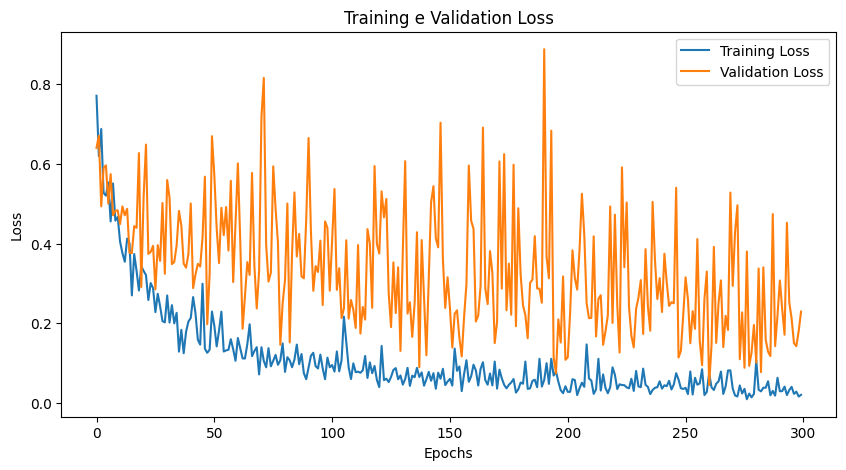

In [34]:
plot_comparison(train_losses, val_losses)

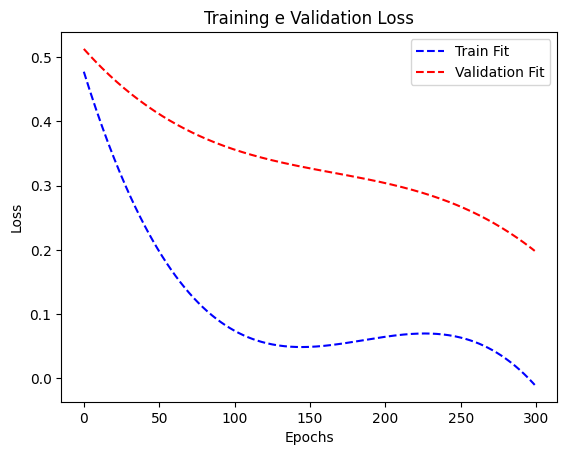

In [35]:
plot_equation(train_losses, val_losses)

In [36]:
vgg.load_state_dict(torch.load(model_save_path))
vgg.to(device)
print('')

In [37]:
preds, labels = evaluate_model(vgg, test_loader)
accuracy, conf_matrix, precision, recall, f1_score = calculate_metrics(preds, labels)

In [38]:
print_results(accuracy, conf_matrix, precision, recall, f1_score)

Acurácia: 0.7500
Matriz de Confusão:
[[4 0]
 [2 2]]
Precisão: 0.8333
Recall: 0.7500
F1 Score: 0.7333


## Modelo 3 - Inception

In [39]:
inception = torchvision.models.inception_v3(weights=torchvision.models.Inception_V3_Weights.DEFAULT)

In [40]:
inception.fc = nn.Linear(2048, 2)

In [41]:
for name, params in inception.named_parameters():
    if not ('fc' in name or 'AuxLogits.fc' in name):
        params.requires_grad = False

In [42]:
inception.to(device)
optimizer = optim.Adam(inception.parameters(), lr=0.0001)
model_save_path = 'top_inception'

In [43]:
train_losses, val_losses = train(inception, train_loader, val_loader, optimizer, criterion, epochs, early_stop_patience, model_save_path)

Epoch 1/300: 100%|███████████████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  1.89it/s]


Epoch: 1 | Train Loss: 0.6668 | Val Loss: 0.7347


Epoch 2/300: 100%|███████████████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  1.86it/s]


Epoch: 2 | Train Loss: 0.7035 | Val Loss: 0.7296


Epoch 3/300: 100%|███████████████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  1.86it/s]


Epoch: 3 | Train Loss: 0.6816 | Val Loss: 0.7273


Epoch 4/300: 100%|███████████████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  1.88it/s]


Epoch: 4 | Train Loss: 0.7260 | Val Loss: 0.7105


Epoch 5/300: 100%|███████████████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  1.87it/s]


Epoch: 5 | Train Loss: 0.6704 | Val Loss: 0.7484


Epoch 6/300: 100%|███████████████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  1.92it/s]


Epoch: 6 | Train Loss: 0.6942 | Val Loss: 0.7008


Epoch 7/300: 100%|███████████████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  1.90it/s]


Epoch: 7 | Train Loss: 0.6168 | Val Loss: 0.7088


Epoch 8/300: 100%|███████████████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  1.91it/s]


Epoch: 8 | Train Loss: 0.6321 | Val Loss: 0.6910


Epoch 9/300: 100%|███████████████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  1.91it/s]


Epoch: 9 | Train Loss: 0.6689 | Val Loss: 0.6652


Epoch 10/300: 100%|██████████████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  1.93it/s]


Epoch: 10 | Train Loss: 0.6655 | Val Loss: 0.7025


Epoch 11/300: 100%|██████████████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  1.88it/s]


Epoch: 11 | Train Loss: 0.6279 | Val Loss: 0.7372


Epoch 12/300: 100%|██████████████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  1.90it/s]


Epoch: 12 | Train Loss: 0.6207 | Val Loss: 0.6538


Epoch 13/300: 100%|██████████████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  1.88it/s]


Epoch: 13 | Train Loss: 0.6629 | Val Loss: 0.6672


Epoch 14/300: 100%|██████████████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  1.93it/s]


Epoch: 14 | Train Loss: 0.6548 | Val Loss: 0.7353


Epoch 15/300: 100%|██████████████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  1.98it/s]


Epoch: 15 | Train Loss: 0.6368 | Val Loss: 0.6818


Epoch 16/300: 100%|██████████████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  1.95it/s]


Epoch: 16 | Train Loss: 0.6156 | Val Loss: 0.6945


Epoch 17/300: 100%|██████████████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  1.89it/s]


Epoch: 17 | Train Loss: 0.6444 | Val Loss: 0.6622


Epoch 18/300: 100%|██████████████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  1.94it/s]


Epoch: 18 | Train Loss: 0.6425 | Val Loss: 0.6489


Epoch 19/300: 100%|██████████████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  1.89it/s]


Epoch: 19 | Train Loss: 0.6137 | Val Loss: 0.6711


Epoch 20/300: 100%|██████████████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  1.87it/s]


Epoch: 20 | Train Loss: 0.5848 | Val Loss: 0.7198


Epoch 21/300: 100%|██████████████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  1.95it/s]


Epoch: 21 | Train Loss: 0.6079 | Val Loss: 0.7125


Epoch 22/300: 100%|██████████████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  1.96it/s]


Epoch: 22 | Train Loss: 0.5819 | Val Loss: 0.6658


Epoch 23/300: 100%|██████████████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  1.90it/s]


Epoch: 23 | Train Loss: 0.6179 | Val Loss: 0.7393


Epoch 24/300: 100%|██████████████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  1.92it/s]


Epoch: 24 | Train Loss: 0.6033 | Val Loss: 0.7098


Epoch 25/300: 100%|██████████████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  1.93it/s]


Epoch: 25 | Train Loss: 0.6038 | Val Loss: 0.6632


Epoch 26/300: 100%|██████████████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  1.94it/s]


Epoch: 26 | Train Loss: 0.6107 | Val Loss: 0.7114


Epoch 27/300: 100%|██████████████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  2.01it/s]


Epoch: 27 | Train Loss: 0.6085 | Val Loss: 0.7328


Epoch 28/300: 100%|██████████████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  1.98it/s]


Epoch: 28 | Train Loss: 0.5795 | Val Loss: 0.7385


Epoch 29/300: 100%|██████████████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  1.93it/s]


Epoch: 29 | Train Loss: 0.6443 | Val Loss: 0.6229


Epoch 30/300: 100%|██████████████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  1.95it/s]


Epoch: 30 | Train Loss: 0.6071 | Val Loss: 0.6414


Epoch 31/300: 100%|██████████████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  1.89it/s]


Epoch: 31 | Train Loss: 0.5622 | Val Loss: 0.7472


Epoch 32/300: 100%|██████████████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  1.87it/s]


Epoch: 32 | Train Loss: 0.5708 | Val Loss: 0.6820


Epoch 33/300: 100%|██████████████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  1.89it/s]


Epoch: 33 | Train Loss: 0.5401 | Val Loss: 0.6545


Epoch 34/300: 100%|██████████████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  1.97it/s]


Epoch: 34 | Train Loss: 0.5549 | Val Loss: 0.6908


Epoch 35/300: 100%|██████████████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  1.92it/s]


Epoch: 35 | Train Loss: 0.5459 | Val Loss: 0.6409


Epoch 36/300: 100%|██████████████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  1.92it/s]


Epoch: 36 | Train Loss: 0.5642 | Val Loss: 0.6245


Epoch 37/300: 100%|██████████████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  1.96it/s]


Epoch: 37 | Train Loss: 0.5552 | Val Loss: 0.6432


Epoch 38/300: 100%|██████████████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  1.89it/s]


Epoch: 38 | Train Loss: 0.5518 | Val Loss: 0.6704


Epoch 39/300: 100%|██████████████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  1.94it/s]


Epoch: 39 | Train Loss: 0.5495 | Val Loss: 0.6945


Epoch 40/300: 100%|██████████████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  1.93it/s]


Epoch: 40 | Train Loss: 0.5812 | Val Loss: 0.6333


Epoch 41/300: 100%|██████████████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  1.97it/s]


Epoch: 41 | Train Loss: 0.5237 | Val Loss: 0.6637


Epoch 42/300: 100%|██████████████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  1.93it/s]


Epoch: 42 | Train Loss: 0.5376 | Val Loss: 0.6982


Epoch 43/300: 100%|██████████████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  1.93it/s]


Epoch: 43 | Train Loss: 0.5412 | Val Loss: 0.5987


Epoch 44/300: 100%|██████████████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  1.90it/s]


Epoch: 44 | Train Loss: 0.5395 | Val Loss: 0.7195


Epoch 45/300: 100%|██████████████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  1.87it/s]


Epoch: 45 | Train Loss: 0.5717 | Val Loss: 0.6241


Epoch 46/300: 100%|██████████████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  1.87it/s]


Epoch: 46 | Train Loss: 0.5496 | Val Loss: 0.7004


Epoch 47/300: 100%|██████████████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  1.89it/s]


Epoch: 47 | Train Loss: 0.5727 | Val Loss: 0.6632


Epoch 48/300: 100%|██████████████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  1.93it/s]


Epoch: 48 | Train Loss: 0.5265 | Val Loss: 0.6767


Epoch 49/300: 100%|██████████████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  1.91it/s]


Epoch: 49 | Train Loss: 0.4828 | Val Loss: 0.6928


Epoch 50/300: 100%|██████████████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  1.98it/s]


Epoch: 50 | Train Loss: 0.5384 | Val Loss: 0.6628


Epoch 51/300: 100%|██████████████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  1.98it/s]


Epoch: 51 | Train Loss: 0.5324 | Val Loss: 0.6477


Epoch 52/300: 100%|██████████████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  1.97it/s]


Epoch: 52 | Train Loss: 0.5264 | Val Loss: 0.6685


Epoch 53/300: 100%|██████████████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  1.90it/s]


Epoch: 53 | Train Loss: 0.5881 | Val Loss: 0.6295


Epoch 54/300: 100%|██████████████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  1.98it/s]


Epoch: 54 | Train Loss: 0.4967 | Val Loss: 0.7073


Epoch 55/300: 100%|██████████████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  2.01it/s]


Epoch: 55 | Train Loss: 0.6057 | Val Loss: 0.6734


Epoch 56/300: 100%|██████████████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  1.94it/s]


Epoch: 56 | Train Loss: 0.4950 | Val Loss: 0.6460


Epoch 57/300: 100%|██████████████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  1.95it/s]


Epoch: 57 | Train Loss: 0.4834 | Val Loss: 0.6315


Epoch 58/300: 100%|██████████████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  1.93it/s]


Epoch: 58 | Train Loss: 0.4621 | Val Loss: 0.6678


Epoch 59/300: 100%|██████████████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  1.96it/s]


Epoch: 59 | Train Loss: 0.5150 | Val Loss: 0.6151


Epoch 60/300: 100%|██████████████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  1.94it/s]


Epoch: 60 | Train Loss: 0.5182 | Val Loss: 0.6611


Epoch 61/300: 100%|██████████████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  1.99it/s]


Epoch: 61 | Train Loss: 0.4793 | Val Loss: 0.6063


Epoch 62/300: 100%|██████████████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  1.95it/s]


Epoch: 62 | Train Loss: 0.4754 | Val Loss: 0.5768


Epoch 63/300: 100%|██████████████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  1.92it/s]


Epoch: 63 | Train Loss: 0.4521 | Val Loss: 0.6211


Epoch 64/300: 100%|██████████████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  1.99it/s]


Epoch: 64 | Train Loss: 0.4741 | Val Loss: 0.6425


Epoch 65/300: 100%|██████████████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  1.94it/s]


Epoch: 65 | Train Loss: 0.4327 | Val Loss: 0.6305


Epoch 66/300: 100%|██████████████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  1.92it/s]


Epoch: 66 | Train Loss: 0.4994 | Val Loss: 0.6197


Epoch 67/300: 100%|██████████████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  1.89it/s]


Epoch: 67 | Train Loss: 0.5308 | Val Loss: 0.6664


Epoch 68/300: 100%|██████████████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  1.89it/s]


Epoch: 68 | Train Loss: 0.4583 | Val Loss: 0.5939


Epoch 69/300: 100%|██████████████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  1.91it/s]


Epoch: 69 | Train Loss: 0.5447 | Val Loss: 0.7436


Epoch 70/300: 100%|██████████████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  1.95it/s]


Epoch: 70 | Train Loss: 0.4382 | Val Loss: 0.6768


Epoch 71/300: 100%|██████████████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  1.95it/s]


Epoch: 71 | Train Loss: 0.5041 | Val Loss: 0.6969


Epoch 72/300: 100%|██████████████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  1.90it/s]


Epoch: 72 | Train Loss: 0.4838 | Val Loss: 0.6376


Epoch 73/300: 100%|██████████████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  1.90it/s]


Epoch: 73 | Train Loss: 0.5311 | Val Loss: 0.6735


Epoch 74/300: 100%|██████████████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  1.88it/s]


Epoch: 74 | Train Loss: 0.3972 | Val Loss: 0.7552


Epoch 75/300: 100%|██████████████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  1.96it/s]


Epoch: 75 | Train Loss: 0.5450 | Val Loss: 0.6697


Epoch 76/300: 100%|██████████████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  1.99it/s]


Epoch: 76 | Train Loss: 0.4462 | Val Loss: 0.6300


Epoch 77/300: 100%|██████████████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  1.97it/s]


Epoch: 77 | Train Loss: 0.4480 | Val Loss: 0.7460


Epoch 78/300: 100%|██████████████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  1.95it/s]


Epoch: 78 | Train Loss: 0.5015 | Val Loss: 0.6643


Epoch 79/300: 100%|██████████████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  1.98it/s]


Epoch: 79 | Train Loss: 0.4732 | Val Loss: 0.5674


Epoch 80/300: 100%|██████████████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  1.93it/s]


Epoch: 80 | Train Loss: 0.4667 | Val Loss: 0.8012


Epoch 81/300: 100%|██████████████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  1.95it/s]


Epoch: 81 | Train Loss: 0.4268 | Val Loss: 0.5972


Epoch 82/300: 100%|██████████████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  1.98it/s]


Epoch: 82 | Train Loss: 0.4878 | Val Loss: 0.6557


Epoch 83/300: 100%|██████████████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  1.95it/s]


Epoch: 83 | Train Loss: 0.4951 | Val Loss: 0.6406


Epoch 84/300: 100%|██████████████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  1.98it/s]


Epoch: 84 | Train Loss: 0.4714 | Val Loss: 0.6176


Epoch 85/300: 100%|██████████████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  1.98it/s]


Epoch: 85 | Train Loss: 0.4338 | Val Loss: 0.7374


Epoch 86/300: 100%|██████████████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  1.99it/s]


Epoch: 86 | Train Loss: 0.4163 | Val Loss: 0.6216


Epoch 87/300: 100%|██████████████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  1.99it/s]


Epoch: 87 | Train Loss: 0.4964 | Val Loss: 0.5416


Epoch 88/300: 100%|██████████████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  1.95it/s]


Epoch: 88 | Train Loss: 0.4316 | Val Loss: 0.6980


Epoch 89/300: 100%|██████████████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  1.99it/s]


Epoch: 89 | Train Loss: 0.4878 | Val Loss: 0.6517


Epoch 90/300: 100%|██████████████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  1.96it/s]


Epoch: 90 | Train Loss: 0.4637 | Val Loss: 0.7058


Epoch 91/300: 100%|██████████████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  1.90it/s]


Epoch: 91 | Train Loss: 0.4006 | Val Loss: 0.7379


Epoch 92/300: 100%|██████████████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  1.90it/s]


Epoch: 92 | Train Loss: 0.4189 | Val Loss: 0.7797


Epoch 93/300: 100%|██████████████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  1.93it/s]


Epoch: 93 | Train Loss: 0.4845 | Val Loss: 0.6651


Epoch 94/300: 100%|██████████████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  1.95it/s]


Epoch: 94 | Train Loss: 0.4486 | Val Loss: 0.6576


Epoch 95/300: 100%|██████████████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  1.97it/s]


Epoch: 95 | Train Loss: 0.4286 | Val Loss: 0.6072


Epoch 96/300: 100%|██████████████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  1.99it/s]


Epoch: 96 | Train Loss: 0.4574 | Val Loss: 0.5653


Epoch 97/300: 100%|██████████████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  2.03it/s]


Epoch: 97 | Train Loss: 0.4324 | Val Loss: 0.7353


Epoch 98/300: 100%|██████████████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  2.01it/s]


Epoch: 98 | Train Loss: 0.5853 | Val Loss: 0.7584


Epoch 99/300: 100%|██████████████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  1.99it/s]


Epoch: 99 | Train Loss: 0.4018 | Val Loss: 0.5955


Epoch 100/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  2.01it/s]


Epoch: 100 | Train Loss: 0.4414 | Val Loss: 0.6638


Epoch 101/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  2.01it/s]


Epoch: 101 | Train Loss: 0.4717 | Val Loss: 0.8570


Epoch 102/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  2.03it/s]


Epoch: 102 | Train Loss: 0.4306 | Val Loss: 0.6906


Epoch 103/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  2.02it/s]


Epoch: 103 | Train Loss: 0.4432 | Val Loss: 0.6602


Epoch 104/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  2.01it/s]


Epoch: 104 | Train Loss: 0.4850 | Val Loss: 0.7422


Epoch 105/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  1.99it/s]


Epoch: 105 | Train Loss: 0.4797 | Val Loss: 0.7117


Epoch 106/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  2.01it/s]


Epoch: 106 | Train Loss: 0.4363 | Val Loss: 0.7738


Epoch 107/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  2.02it/s]


Epoch: 107 | Train Loss: 0.4285 | Val Loss: 0.6891


Epoch 108/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  1.94it/s]


Epoch: 108 | Train Loss: 0.4186 | Val Loss: 0.8042


Epoch 109/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  1.99it/s]


Epoch: 109 | Train Loss: 0.4151 | Val Loss: 0.7026


Epoch 110/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  2.05it/s]


Epoch: 110 | Train Loss: 0.4021 | Val Loss: 0.7056


Epoch 111/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  2.02it/s]


Epoch: 111 | Train Loss: 0.4267 | Val Loss: 0.6763


Epoch 112/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  1.97it/s]


Epoch: 112 | Train Loss: 0.3605 | Val Loss: 0.7156


Epoch 113/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  1.99it/s]


Epoch: 113 | Train Loss: 0.3863 | Val Loss: 0.5522


Epoch 114/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  1.96it/s]


Epoch: 114 | Train Loss: 0.3725 | Val Loss: 0.6632


Epoch 115/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  2.01it/s]


Epoch: 115 | Train Loss: 0.5096 | Val Loss: 0.8342


Epoch 116/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  2.01it/s]


Epoch: 116 | Train Loss: 0.3938 | Val Loss: 0.6500


Epoch 117/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  1.99it/s]


Epoch: 117 | Train Loss: 0.4306 | Val Loss: 0.6622


Epoch 118/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  1.95it/s]


Epoch: 118 | Train Loss: 0.4608 | Val Loss: 0.6622


Epoch 119/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  1.99it/s]


Epoch: 119 | Train Loss: 0.3707 | Val Loss: 0.6290


Epoch 120/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  2.03it/s]


Epoch: 120 | Train Loss: 0.3584 | Val Loss: 0.6675


Epoch 121/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  1.99it/s]


Epoch: 121 | Train Loss: 0.4980 | Val Loss: 0.6165


Epoch 122/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  2.03it/s]


Epoch: 122 | Train Loss: 0.4689 | Val Loss: 0.6097


Epoch 123/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  1.98it/s]


Epoch: 123 | Train Loss: 0.4107 | Val Loss: 0.5373


Epoch 124/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  1.89it/s]


Epoch: 124 | Train Loss: 0.3640 | Val Loss: 0.6125


Epoch 125/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  1.95it/s]


Epoch: 125 | Train Loss: 0.4282 | Val Loss: 0.6914


Epoch 126/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  1.95it/s]


Epoch: 126 | Train Loss: 0.3987 | Val Loss: 0.7444


Epoch 127/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  2.01it/s]


Epoch: 127 | Train Loss: 0.3386 | Val Loss: 0.7386


Epoch 128/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  2.00it/s]


Epoch: 128 | Train Loss: 0.3722 | Val Loss: 0.6304


Epoch 129/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  1.93it/s]


Epoch: 129 | Train Loss: 0.4260 | Val Loss: 0.8265


Epoch 130/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  1.95it/s]


Epoch: 130 | Train Loss: 0.3985 | Val Loss: 0.6039


Epoch 131/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  1.98it/s]


Epoch: 131 | Train Loss: 0.4387 | Val Loss: 0.6144


Epoch 132/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  1.98it/s]


Epoch: 132 | Train Loss: 0.4422 | Val Loss: 0.5611


Epoch 133/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  1.95it/s]


Epoch: 133 | Train Loss: 0.4014 | Val Loss: 0.6727


Epoch 134/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  1.96it/s]


Epoch: 134 | Train Loss: 0.4985 | Val Loss: 0.7088


Epoch 135/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  2.01it/s]


Epoch: 135 | Train Loss: 0.3784 | Val Loss: 0.7643


Epoch 136/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  1.94it/s]


Epoch: 136 | Train Loss: 0.3993 | Val Loss: 0.7017


Epoch 137/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  1.91it/s]


Epoch: 137 | Train Loss: 0.4308 | Val Loss: 0.7086


Epoch 138/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  1.91it/s]


Epoch: 138 | Train Loss: 0.4226 | Val Loss: 0.7200


Epoch 139/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  1.98it/s]


Epoch: 139 | Train Loss: 0.3678 | Val Loss: 0.6377


Epoch 140/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  2.00it/s]


Epoch: 140 | Train Loss: 0.3556 | Val Loss: 0.6674


Epoch 141/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  1.97it/s]


Epoch: 141 | Train Loss: 0.3403 | Val Loss: 0.7533


Epoch 142/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  2.04it/s]


Epoch: 142 | Train Loss: 0.3212 | Val Loss: 0.6465


Epoch 143/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  1.98it/s]


Epoch: 143 | Train Loss: 0.4317 | Val Loss: 0.6889


Epoch 144/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  1.95it/s]


Epoch: 144 | Train Loss: 0.5095 | Val Loss: 0.5822


Epoch 145/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  1.96it/s]


Epoch: 145 | Train Loss: 0.3625 | Val Loss: 0.5756


Epoch 146/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  1.94it/s]


Epoch: 146 | Train Loss: 0.3667 | Val Loss: 0.6300


Epoch 147/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  2.02it/s]


Epoch: 147 | Train Loss: 0.3662 | Val Loss: 0.7531


Epoch 148/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  1.92it/s]


Epoch: 148 | Train Loss: 0.3160 | Val Loss: 0.6738


Epoch 149/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  2.03it/s]


Epoch: 149 | Train Loss: 0.4097 | Val Loss: 0.6647


Epoch 150/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  1.94it/s]


Epoch: 150 | Train Loss: 0.3589 | Val Loss: 0.7305


Epoch 151/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  1.96it/s]


Epoch: 151 | Train Loss: 0.4235 | Val Loss: 0.6835


Epoch 152/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  1.97it/s]


Epoch: 152 | Train Loss: 0.2967 | Val Loss: 0.7688


Epoch 153/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  1.96it/s]


Epoch: 153 | Train Loss: 0.4317 | Val Loss: 0.6855


Epoch 154/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  2.02it/s]


Epoch: 154 | Train Loss: 0.4175 | Val Loss: 0.7175


Epoch 155/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  2.01it/s]


Epoch: 155 | Train Loss: 0.3145 | Val Loss: 0.6918


Epoch 156/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  2.04it/s]


Epoch: 156 | Train Loss: 0.3241 | Val Loss: 0.4748


Epoch 157/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  1.98it/s]


Epoch: 157 | Train Loss: 0.5094 | Val Loss: 0.6433


Epoch 158/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  1.99it/s]


Epoch: 158 | Train Loss: 0.4251 | Val Loss: 0.5894


Epoch 159/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  1.98it/s]


Epoch: 159 | Train Loss: 0.4569 | Val Loss: 0.6561


Epoch 160/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  1.99it/s]


Epoch: 160 | Train Loss: 0.3696 | Val Loss: 0.7524


Epoch 161/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  1.97it/s]


Epoch: 161 | Train Loss: 0.3400 | Val Loss: 0.6445


Epoch 162/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  2.02it/s]


Epoch: 162 | Train Loss: 0.3897 | Val Loss: 0.7762


Epoch 163/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  1.94it/s]


Epoch: 163 | Train Loss: 0.3493 | Val Loss: 0.6989


Epoch 164/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  1.94it/s]


Epoch: 164 | Train Loss: 0.3889 | Val Loss: 0.6901


Epoch 165/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  1.92it/s]


Epoch: 165 | Train Loss: 0.3071 | Val Loss: 0.6643


Epoch 166/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  1.89it/s]


Epoch: 166 | Train Loss: 0.3374 | Val Loss: 0.7382


Epoch 167/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  2.00it/s]


Epoch: 167 | Train Loss: 0.4085 | Val Loss: 0.6481


Epoch 168/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  2.01it/s]


Epoch: 168 | Train Loss: 0.4160 | Val Loss: 0.8227


Epoch 169/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  1.98it/s]


Epoch: 169 | Train Loss: 0.3808 | Val Loss: 0.6287


Epoch 170/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  2.02it/s]


Epoch: 170 | Train Loss: 0.4106 | Val Loss: 0.6154


Epoch 171/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  1.97it/s]


Epoch: 171 | Train Loss: 0.4150 | Val Loss: 0.5508


Epoch 172/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  2.03it/s]


Epoch: 172 | Train Loss: 0.3142 | Val Loss: 0.6244


Epoch 173/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  1.97it/s]


Epoch: 173 | Train Loss: 0.3225 | Val Loss: 0.5337


Epoch 174/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  1.96it/s]


Epoch: 174 | Train Loss: 0.4428 | Val Loss: 0.7070


Epoch 175/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  2.00it/s]


Epoch: 175 | Train Loss: 0.3548 | Val Loss: 0.6006


Epoch 176/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  1.93it/s]


Epoch: 176 | Train Loss: 0.2840 | Val Loss: 0.5627


Epoch 177/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  1.94it/s]


Epoch: 177 | Train Loss: 0.3571 | Val Loss: 0.7239


Epoch 178/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  1.87it/s]


Epoch: 178 | Train Loss: 0.3211 | Val Loss: 0.7720


Epoch 179/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  1.97it/s]


Epoch: 179 | Train Loss: 0.4340 | Val Loss: 0.6650


Epoch 180/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  1.93it/s]


Epoch: 180 | Train Loss: 0.3178 | Val Loss: 0.7711


Epoch 181/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  2.06it/s]


Epoch: 181 | Train Loss: 0.3627 | Val Loss: 0.7273


Epoch 182/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  1.98it/s]


Epoch: 182 | Train Loss: 0.4212 | Val Loss: 0.7888


Epoch 183/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  1.96it/s]


Epoch: 183 | Train Loss: 0.3580 | Val Loss: 0.6602


Epoch 184/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  2.01it/s]


Epoch: 184 | Train Loss: 0.3443 | Val Loss: 0.6819


Epoch 185/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  1.94it/s]


Epoch: 185 | Train Loss: 0.3975 | Val Loss: 0.6698


Epoch 186/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  1.98it/s]


Epoch: 186 | Train Loss: 0.3538 | Val Loss: 0.7177


Epoch 187/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  1.98it/s]


Epoch: 187 | Train Loss: 0.4272 | Val Loss: 0.6390


Epoch 188/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  1.96it/s]


Epoch: 188 | Train Loss: 0.2922 | Val Loss: 0.7817


Epoch 189/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  1.97it/s]


Epoch: 189 | Train Loss: 0.3990 | Val Loss: 0.5749


Epoch 190/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  1.94it/s]


Epoch: 190 | Train Loss: 0.3430 | Val Loss: 0.7846


Epoch 191/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  1.96it/s]


Epoch: 191 | Train Loss: 0.3489 | Val Loss: 0.7297


Epoch 192/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  2.02it/s]


Epoch: 192 | Train Loss: 0.3562 | Val Loss: 0.7405


Epoch 193/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  2.01it/s]


Epoch: 193 | Train Loss: 0.4078 | Val Loss: 0.6109


Epoch 194/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  2.01it/s]


Epoch: 194 | Train Loss: 0.3556 | Val Loss: 0.8681


Epoch 195/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  2.04it/s]


Epoch: 195 | Train Loss: 0.2979 | Val Loss: 0.7397


Epoch 196/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  2.07it/s]


Epoch: 196 | Train Loss: 0.2774 | Val Loss: 0.8366


Epoch 197/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  2.05it/s]


Epoch: 197 | Train Loss: 0.4139 | Val Loss: 0.8682


Epoch 198/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  1.92it/s]


Epoch: 198 | Train Loss: 0.3724 | Val Loss: 0.5646


Epoch 199/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  2.00it/s]


Epoch: 199 | Train Loss: 0.4294 | Val Loss: 0.6128


Epoch 200/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  2.03it/s]


Epoch: 200 | Train Loss: 0.2576 | Val Loss: 0.5849


Epoch 201/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  2.04it/s]


Epoch: 201 | Train Loss: 0.3291 | Val Loss: 0.8375


Epoch 202/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  1.99it/s]


Epoch: 202 | Train Loss: 0.3238 | Val Loss: 0.6574


Epoch 203/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  1.97it/s]


Epoch: 203 | Train Loss: 0.2998 | Val Loss: 0.9869


Epoch 204/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  2.01it/s]


Epoch: 204 | Train Loss: 0.3872 | Val Loss: 0.6283


Epoch 205/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  1.98it/s]


Epoch: 205 | Train Loss: 0.3280 | Val Loss: 0.5889


Epoch 206/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  2.01it/s]


Epoch: 206 | Train Loss: 0.4348 | Val Loss: 0.7436


Epoch 207/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  1.96it/s]


Epoch: 207 | Train Loss: 0.3459 | Val Loss: 0.7736


Epoch 208/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  1.88it/s]


Epoch: 208 | Train Loss: 0.3222 | Val Loss: 0.6691


Epoch 209/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  1.90it/s]


Epoch: 209 | Train Loss: 0.3228 | Val Loss: 0.6595


Epoch 210/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  1.96it/s]


Epoch: 210 | Train Loss: 0.3121 | Val Loss: 0.4414


Epoch 211/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  1.92it/s]


Epoch: 211 | Train Loss: 0.3881 | Val Loss: 0.6240


Epoch 212/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  1.97it/s]


Epoch: 212 | Train Loss: 0.3652 | Val Loss: 0.6846


Epoch 213/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  1.94it/s]


Epoch: 213 | Train Loss: 0.2618 | Val Loss: 0.7323


Epoch 214/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  1.90it/s]


Epoch: 214 | Train Loss: 0.3632 | Val Loss: 0.5953


Epoch 215/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  1.83it/s]


Epoch: 215 | Train Loss: 0.5061 | Val Loss: 0.5627


Epoch 216/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  1.94it/s]


Epoch: 216 | Train Loss: 0.2860 | Val Loss: 0.7700


Epoch 217/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  1.92it/s]


Epoch: 217 | Train Loss: 0.3311 | Val Loss: 0.6160


Epoch 218/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  1.88it/s]


Epoch: 218 | Train Loss: 0.4616 | Val Loss: 0.7817


Epoch 219/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  1.85it/s]


Epoch: 219 | Train Loss: 0.4850 | Val Loss: 0.6968


Epoch 220/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  1.97it/s]


Epoch: 220 | Train Loss: 0.3323 | Val Loss: 0.6475


Epoch 221/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  1.97it/s]


Epoch: 221 | Train Loss: 0.3106 | Val Loss: 0.6149


Epoch 222/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  1.99it/s]


Epoch: 222 | Train Loss: 0.3633 | Val Loss: 0.6918


Epoch 223/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  1.95it/s]


Epoch: 223 | Train Loss: 0.3465 | Val Loss: 0.6028


Epoch 224/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  1.94it/s]


Epoch: 224 | Train Loss: 0.3159 | Val Loss: 0.6535


Epoch 225/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  2.00it/s]


Epoch: 225 | Train Loss: 0.3616 | Val Loss: 0.6523


Epoch 226/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  1.95it/s]


Epoch: 226 | Train Loss: 0.3632 | Val Loss: 0.6276


Epoch 227/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  1.87it/s]


Epoch: 227 | Train Loss: 0.4555 | Val Loss: 0.9792


Epoch 228/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  1.87it/s]


Epoch: 228 | Train Loss: 0.4064 | Val Loss: 0.7563


Epoch 229/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  1.81it/s]


Epoch: 229 | Train Loss: 0.4194 | Val Loss: 0.7904


Epoch 230/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  1.85it/s]


Epoch: 230 | Train Loss: 0.2895 | Val Loss: 0.7281


Epoch 231/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  1.95it/s]


Epoch: 231 | Train Loss: 0.2993 | Val Loss: 0.6600


Epoch 232/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  1.93it/s]


Epoch: 232 | Train Loss: 0.2583 | Val Loss: 0.4914


Epoch 233/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  1.88it/s]


Epoch: 233 | Train Loss: 0.4022 | Val Loss: 0.9499


Epoch 234/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  1.87it/s]


Epoch: 234 | Train Loss: 0.3667 | Val Loss: 0.6833


Epoch 235/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  1.88it/s]


Epoch: 235 | Train Loss: 0.2885 | Val Loss: 0.7619


Epoch 236/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  1.88it/s]


Epoch: 236 | Train Loss: 0.4657 | Val Loss: 0.6874


Epoch 237/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  1.90it/s]


Epoch: 237 | Train Loss: 0.3415 | Val Loss: 0.5985


Epoch 238/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  1.89it/s]


Epoch: 238 | Train Loss: 0.3778 | Val Loss: 0.7843


Epoch 239/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  1.89it/s]


Epoch: 239 | Train Loss: 0.2637 | Val Loss: 0.7314


Epoch 240/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  1.91it/s]


Epoch: 240 | Train Loss: 0.3716 | Val Loss: 0.7957


Epoch 241/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  1.90it/s]


Epoch: 241 | Train Loss: 0.3193 | Val Loss: 0.9449


Epoch 242/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  1.91it/s]


Epoch: 242 | Train Loss: 0.2601 | Val Loss: 0.9033


Epoch 243/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  1.86it/s]


Epoch: 243 | Train Loss: 0.2334 | Val Loss: 0.7305


Epoch 244/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  1.85it/s]


Epoch: 244 | Train Loss: 0.3703 | Val Loss: 0.7969


Epoch 245/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  1.81it/s]


Epoch: 245 | Train Loss: 0.2843 | Val Loss: 0.7043


Epoch 246/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  1.84it/s]


Epoch: 246 | Train Loss: 0.3599 | Val Loss: 0.5110


Epoch 247/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  1.82it/s]


Epoch: 247 | Train Loss: 0.3804 | Val Loss: 0.5646


Epoch 248/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:04<00:00,  1.74it/s]


Epoch: 248 | Train Loss: 0.2204 | Val Loss: 0.6435


Epoch 249/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  1.88it/s]


Epoch: 249 | Train Loss: 0.3831 | Val Loss: 0.7132


Epoch 250/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  1.86it/s]


Epoch: 250 | Train Loss: 0.2657 | Val Loss: 0.7807


Epoch 251/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  1.90it/s]


Epoch: 251 | Train Loss: 0.3099 | Val Loss: 0.7206


Epoch 252/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  1.86it/s]


Epoch: 252 | Train Loss: 0.2919 | Val Loss: 0.8275


Epoch 253/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  1.84it/s]


Epoch: 253 | Train Loss: 0.3877 | Val Loss: 0.6557


Epoch 254/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  1.86it/s]


Epoch: 254 | Train Loss: 0.3332 | Val Loss: 0.6821


Epoch 255/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  1.85it/s]


Epoch: 255 | Train Loss: 0.2898 | Val Loss: 0.6849


Epoch 256/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  1.85it/s]


Epoch: 256 | Train Loss: 0.4368 | Val Loss: 0.7506


Epoch 257/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  1.84it/s]


Epoch: 257 | Train Loss: 0.3576 | Val Loss: 0.8466


Epoch 258/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  1.87it/s]


Epoch: 258 | Train Loss: 0.2459 | Val Loss: 0.5709


Epoch 259/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  1.80it/s]


Epoch: 259 | Train Loss: 0.3691 | Val Loss: 0.5819


Epoch 260/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  1.84it/s]


Epoch: 260 | Train Loss: 0.3512 | Val Loss: 0.7079


Epoch 261/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  1.82it/s]


Epoch: 261 | Train Loss: 0.4572 | Val Loss: 0.7546


Epoch 262/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  1.84it/s]


Epoch: 262 | Train Loss: 0.2659 | Val Loss: 0.8249


Epoch 263/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  1.87it/s]


Epoch: 263 | Train Loss: 0.3009 | Val Loss: 0.6974


Epoch 264/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  1.90it/s]


Epoch: 264 | Train Loss: 0.4122 | Val Loss: 0.7038


Epoch 265/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  1.89it/s]


Epoch: 265 | Train Loss: 0.3179 | Val Loss: 0.8229


Epoch 266/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  1.91it/s]


Epoch: 266 | Train Loss: 0.3286 | Val Loss: 0.6140


Epoch 267/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  1.92it/s]


Epoch: 267 | Train Loss: 0.3509 | Val Loss: 0.8492


Epoch 268/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  1.90it/s]


Epoch: 268 | Train Loss: 0.2919 | Val Loss: 0.5012


Epoch 269/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  1.89it/s]


Epoch: 269 | Train Loss: 0.3941 | Val Loss: 0.7506


Epoch 270/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  1.91it/s]


Epoch: 270 | Train Loss: 0.2314 | Val Loss: 0.6508


Epoch 271/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  1.92it/s]


Epoch: 271 | Train Loss: 0.2752 | Val Loss: 0.8507


Epoch 272/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  1.93it/s]


Epoch: 272 | Train Loss: 0.2844 | Val Loss: 0.8437


Epoch 273/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  1.91it/s]


Epoch: 273 | Train Loss: 0.3976 | Val Loss: 0.6100


Epoch 274/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  1.90it/s]


Epoch: 274 | Train Loss: 0.3231 | Val Loss: 0.8149


Epoch 275/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  1.89it/s]


Epoch: 275 | Train Loss: 0.4587 | Val Loss: 0.7514


Epoch 276/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  1.91it/s]


Epoch: 276 | Train Loss: 0.2420 | Val Loss: 0.7083


Epoch 277/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  1.90it/s]


Epoch: 277 | Train Loss: 0.3833 | Val Loss: 0.7433


Epoch 278/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  1.94it/s]


Epoch: 278 | Train Loss: 0.3438 | Val Loss: 0.6487


Epoch 279/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  1.90it/s]


Epoch: 279 | Train Loss: 0.3411 | Val Loss: 0.6774


Epoch 280/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  1.89it/s]


Epoch: 280 | Train Loss: 0.3840 | Val Loss: 0.7705


Epoch 281/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  1.91it/s]


Epoch: 281 | Train Loss: 0.3434 | Val Loss: 0.7345


Epoch 282/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  1.87it/s]


Epoch: 282 | Train Loss: 0.2698 | Val Loss: 0.7242


Epoch 283/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  1.80it/s]


Epoch: 283 | Train Loss: 0.4099 | Val Loss: 0.5982


Epoch 284/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  1.90it/s]


Epoch: 284 | Train Loss: 0.2366 | Val Loss: 0.8182


Epoch 285/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  1.91it/s]


Epoch: 285 | Train Loss: 0.2925 | Val Loss: 0.9163


Epoch 286/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  1.89it/s]


Epoch: 286 | Train Loss: 0.2311 | Val Loss: 0.6495


Epoch 287/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  1.90it/s]


Epoch: 287 | Train Loss: 0.2889 | Val Loss: 0.7736


Epoch 288/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  1.93it/s]


Epoch: 288 | Train Loss: 0.2915 | Val Loss: 0.6893


Epoch 289/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  1.90it/s]


Epoch: 289 | Train Loss: 0.3496 | Val Loss: 0.7247


Epoch 290/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  1.89it/s]


Epoch: 290 | Train Loss: 0.3507 | Val Loss: 0.8742


Epoch 291/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  1.89it/s]


Epoch: 291 | Train Loss: 0.3948 | Val Loss: 0.4999


Epoch 292/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  1.91it/s]


Epoch: 292 | Train Loss: 0.2583 | Val Loss: 0.9061


Epoch 293/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  1.94it/s]


Epoch: 293 | Train Loss: 0.3585 | Val Loss: 0.5866


Epoch 294/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  1.89it/s]


Epoch: 294 | Train Loss: 0.3162 | Val Loss: 0.6251


Epoch 295/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  1.91it/s]


Epoch: 295 | Train Loss: 0.3818 | Val Loss: 0.5309


Epoch 296/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  1.89it/s]


Epoch: 296 | Train Loss: 0.2841 | Val Loss: 0.7867


Epoch 297/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  1.89it/s]


Epoch: 297 | Train Loss: 0.4997 | Val Loss: 0.7246


Epoch 298/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  1.91it/s]


Epoch: 298 | Train Loss: 0.4037 | Val Loss: 0.9846


Epoch 299/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  1.88it/s]


Epoch: 299 | Train Loss: 0.2595 | Val Loss: 0.6417


Epoch 300/300: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  1.95it/s]


Epoch: 300 | Train Loss: 0.2467 | Val Loss: 0.5644


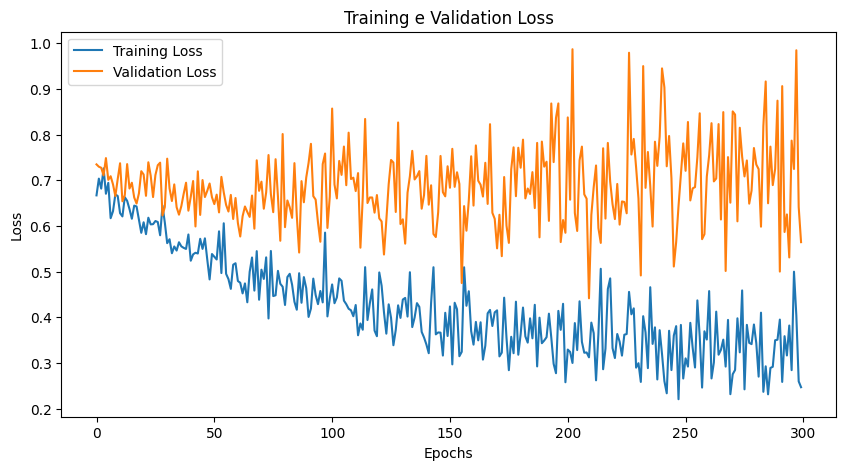

In [44]:
plot_comparison(train_losses, val_losses)

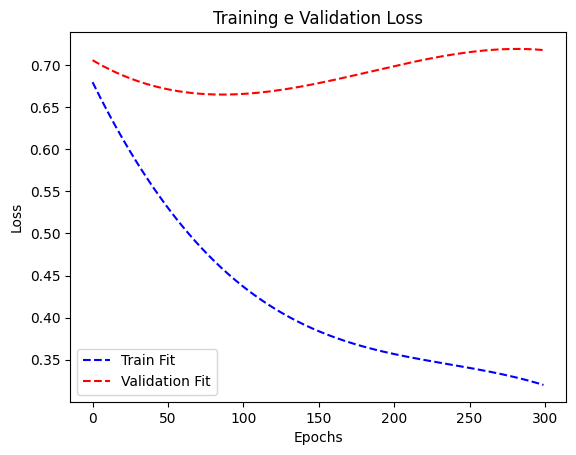

In [45]:
plot_equation(train_losses, val_losses)

In [46]:
inception.load_state_dict(torch.load(model_save_path))
inception.to(device)
print('')

In [47]:
preds, labels = evaluate_model(inception, test_loader)
accuracy, conf_matrix, precision, recall, f1_score = calculate_metrics(preds, labels)

In [48]:
print_results(accuracy, conf_matrix, precision, recall, f1_score)

Acurácia: 0.6250
Matriz de Confusão:
[[4 0]
 [3 1]]
Precisão: 0.7857
Recall: 0.6250
F1 Score: 0.5636


---

# Comparando os Modelos

    - Comparação entre:
        > Resnet
        > VGG
        > Inception


In [49]:
def predict(model, image):
    prediction = model(torch.unsqueeze(image, 0).to(device))
    result = torch.argmax(prediction)
    return 'Coral Falsa' if result == 0 else 'Coral Verdadeira'

---------------------------------------------------------------------------------------------------------------------------------------------------
Real Label: Coral Verdadeira
Resnet Prediction: Coral Verdadeira


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


VGG Prediction: Coral Verdadeira
Inception Prediction: Coral Falsa


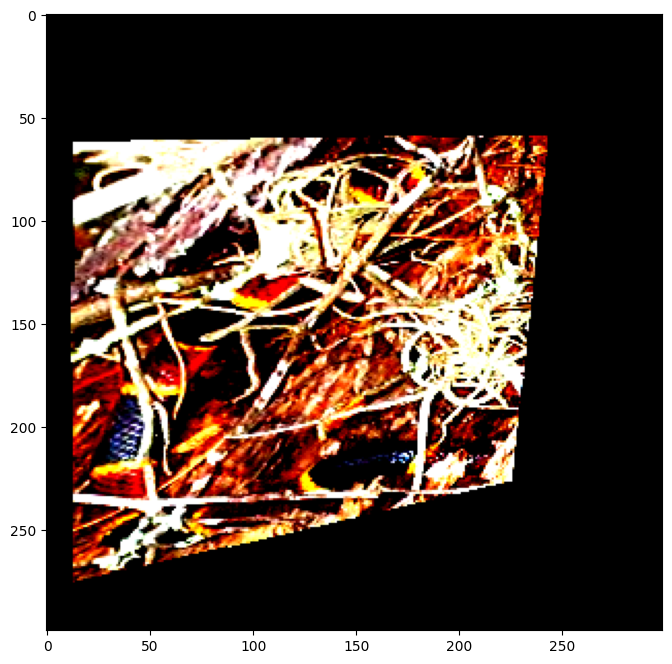

---------------------------------------------------------------------------------------------------------------------------------------------------
---------------------------------------------------------------------------------------------------------------------------------------------------
Real Label: Coral Verdadeira
Resnet Prediction: Coral Verdadeira


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


VGG Prediction: Coral Verdadeira
Inception Prediction: Coral Verdadeira


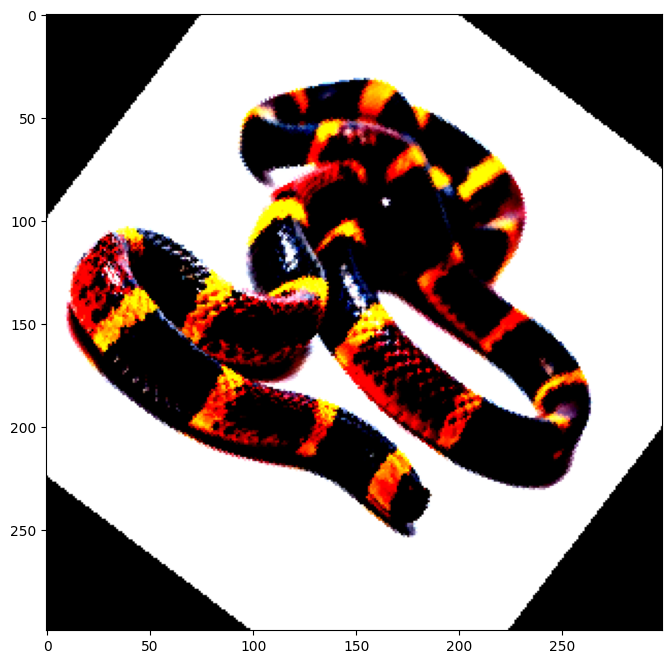

---------------------------------------------------------------------------------------------------------------------------------------------------
---------------------------------------------------------------------------------------------------------------------------------------------------
Real Label: Coral Verdadeira
Resnet Prediction: Coral Falsa


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


VGG Prediction: Coral Verdadeira
Inception Prediction: Coral Falsa


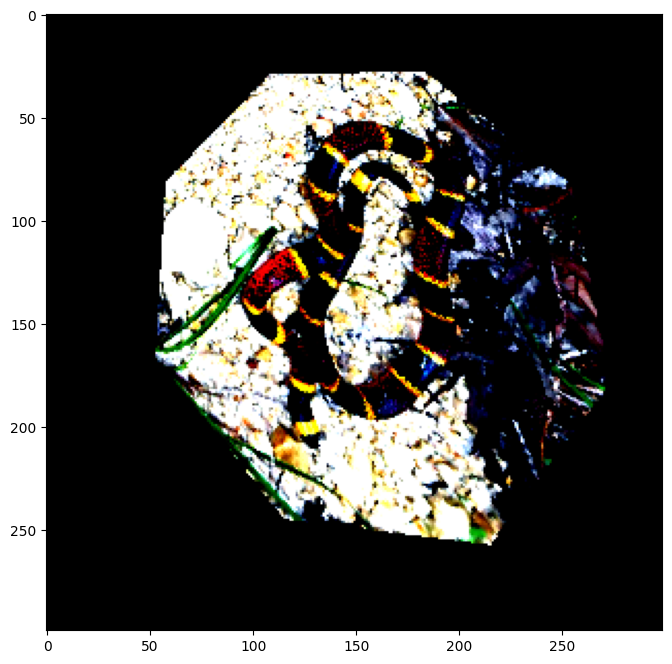

---------------------------------------------------------------------------------------------------------------------------------------------------
---------------------------------------------------------------------------------------------------------------------------------------------------
Real Label: Coral Falsa
Resnet Prediction: Coral Falsa


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


VGG Prediction: Coral Falsa
Inception Prediction: Coral Falsa


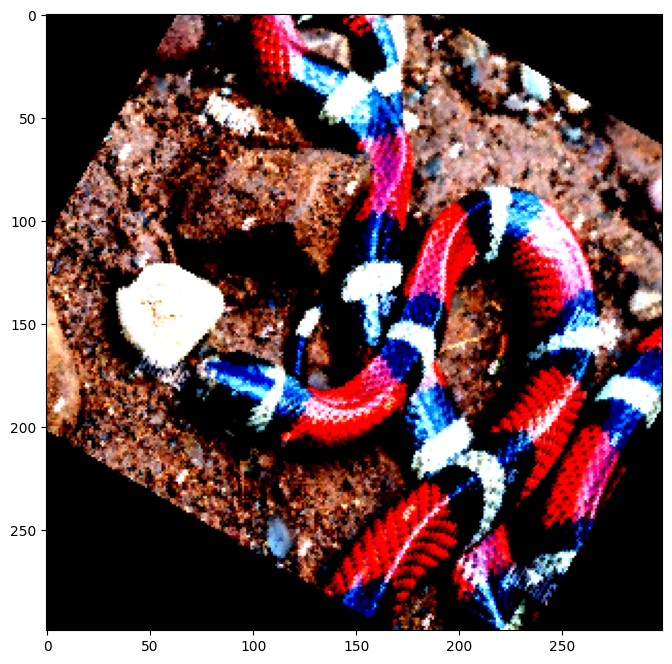

---------------------------------------------------------------------------------------------------------------------------------------------------
---------------------------------------------------------------------------------------------------------------------------------------------------
Real Label: Coral Falsa
Resnet Prediction: Coral Falsa


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


VGG Prediction: Coral Falsa
Inception Prediction: Coral Falsa


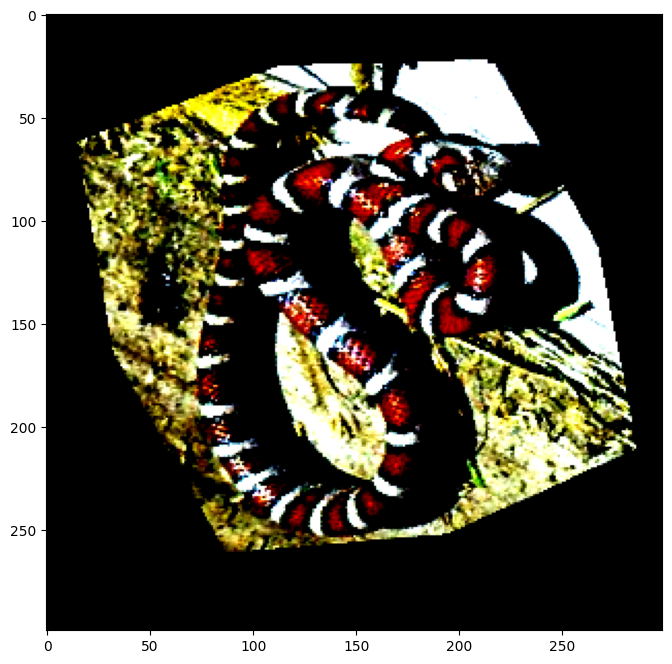

---------------------------------------------------------------------------------------------------------------------------------------------------
---------------------------------------------------------------------------------------------------------------------------------------------------
Real Label: Coral Verdadeira
Resnet Prediction: Coral Falsa


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


VGG Prediction: Coral Falsa
Inception Prediction: Coral Falsa


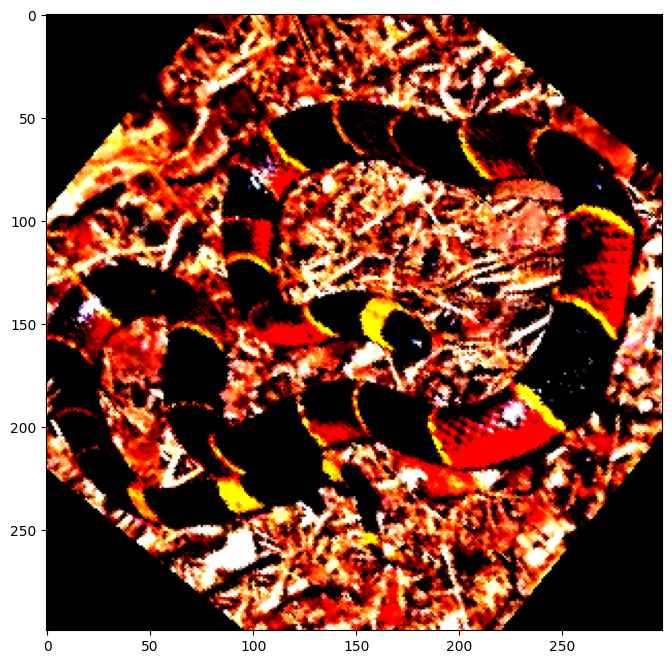

---------------------------------------------------------------------------------------------------------------------------------------------------
---------------------------------------------------------------------------------------------------------------------------------------------------
Real Label: Coral Falsa
Resnet Prediction: Coral Falsa


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


VGG Prediction: Coral Falsa
Inception Prediction: Coral Falsa


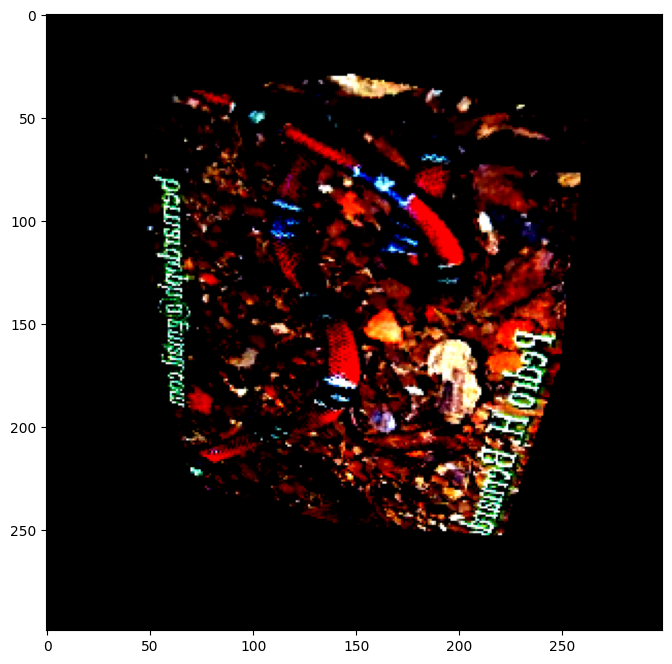

---------------------------------------------------------------------------------------------------------------------------------------------------
---------------------------------------------------------------------------------------------------------------------------------------------------
Real Label: Coral Falsa
Resnet Prediction: Coral Falsa


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


VGG Prediction: Coral Falsa
Inception Prediction: Coral Falsa


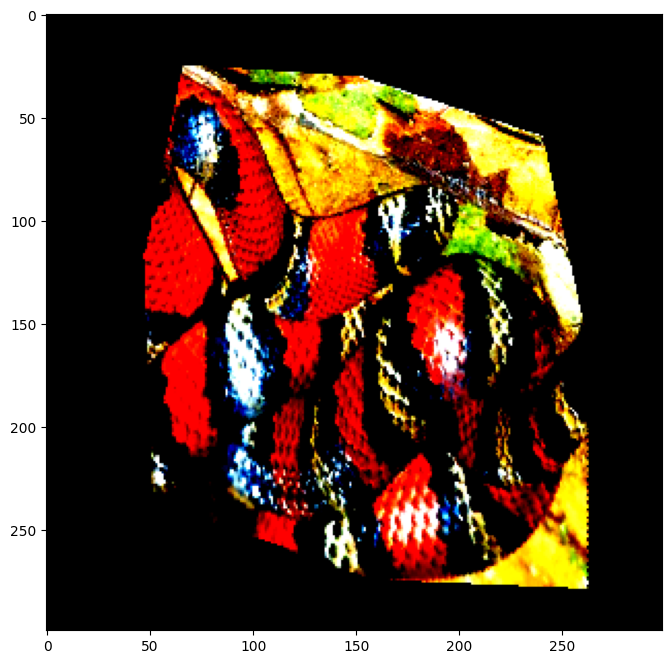

---------------------------------------------------------------------------------------------------------------------------------------------------


In [50]:
for image_index in range(len(test_dataset)):
    image = test_dataset[image_index][0]
    label = 'Coral Verdadeira' if test_dataset[image_index][1] else 'Coral Falsa'
    
    print('---------------------------------------------------------------------------------------------------------------------------------------------------')
    print(f'Real Label: {label}')
    print(f'Resnet Prediction: {predict(resnet, image)}')
    print(f'VGG Prediction: {predict(vgg, image)}')
    print(f'Inception Prediction: {predict(inception, image)}')
    imshow(image)
    print('---------------------------------------------------------------------------------------------------------------------------------------------------')

Real Label: Coral Falsa
Resnet Prediction: Coral Falsa


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


VGG Prediction: Coral Falsa
Inception Prediction: Coral Falsa


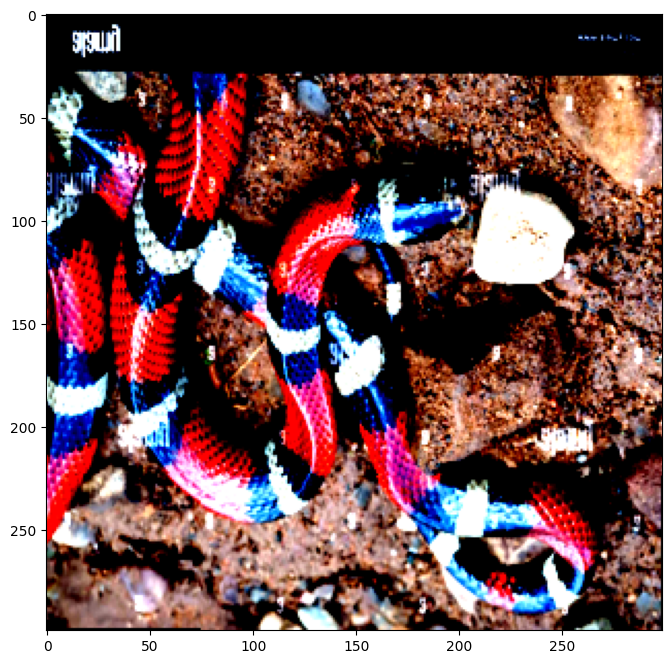

In [51]:
image_index = 3
image = test_dataset[image_index][0]
label = 'Coral Verdadeira' if test_dataset[image_index][1] else 'Coral Falsa'

print(f'Real Label: {label}')
print(f'Resnet Prediction: {predict(resnet, image)}')
print(f'VGG Prediction: {predict(vgg, image)}')
print(f'Inception Prediction: {predict(inception, image)}')
imshow(image)

---

# Testando o modelo


Real Label: Coral Falsa
Resnet Prediction: Coral Falsa


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


VGG Prediction: Coral Falsa
Inception Prediction: Coral Falsa


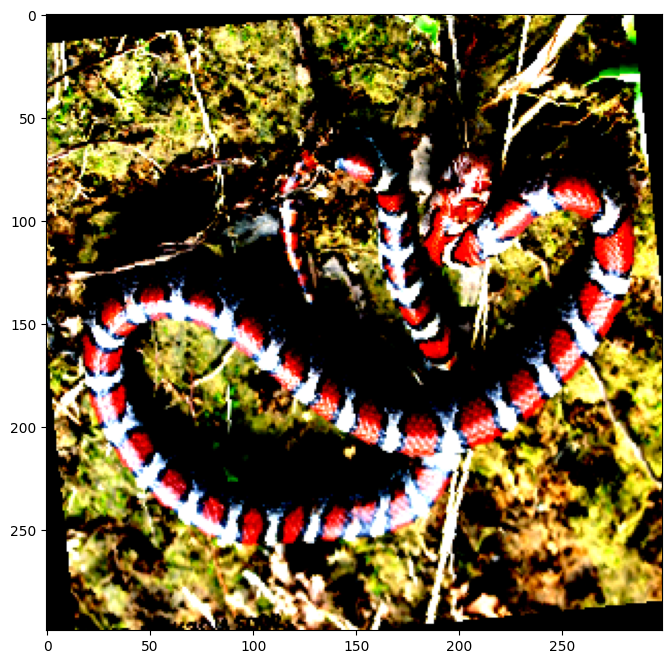

In [52]:
x = Image.open('teste1.jpeg').convert('RGB')
x = transformations(x)
label = 'Coral Falsa'

print(f'Real Label: {label}')
print(f'Resnet Prediction: {predict(resnet, x)}')
print(f'VGG Prediction: {predict(vgg, image)}')
print(f'Inception Prediction: {predict(inception, image)}')

imshow(x)

Real Label: Coral Falsa
Resnet Prediction: Coral Falsa


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


VGG Prediction: Coral Falsa
Inception Prediction: Coral Falsa


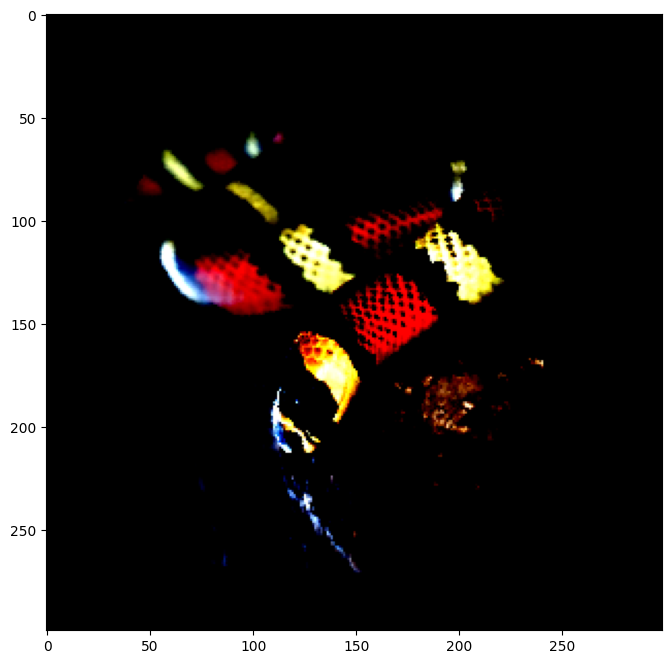

In [53]:
x = Image.open('teste2.jpg').convert('RGB')
x = transformations(x)
label = 'Coral Falsa'

print(f'Real Label: {label}')
print(f'Resnet Prediction: {predict(resnet, x)}')
print(f'VGG Prediction: {predict(vgg, image)}')
print(f'Inception Prediction: {predict(inception, image)}')

imshow(x)

Real Label: Coral Falsa
Resnet Prediction: Coral Verdadeira


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


VGG Prediction: Coral Falsa
Inception Prediction: Coral Falsa


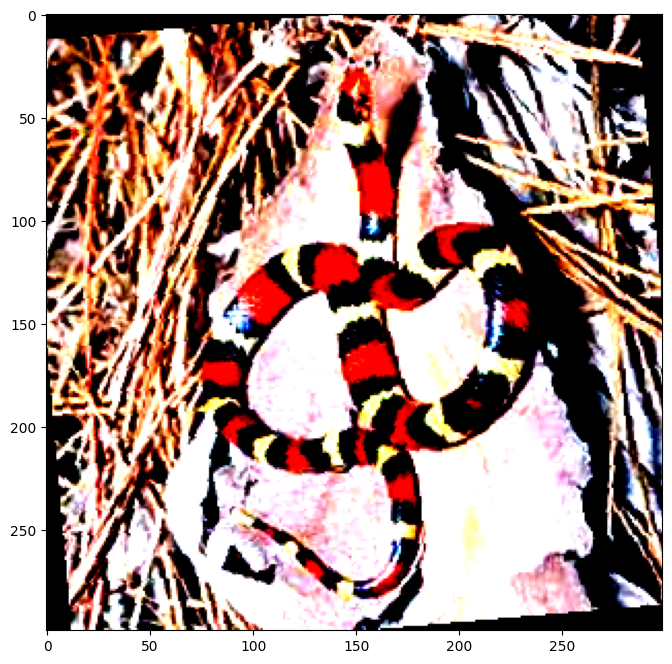

In [54]:
x = Image.open('teste3.jpg').convert('RGB')
x = transformations(x)
label = 'Coral Falsa'

print(f'Real Label: {label}')
print(f'Resnet Prediction: {predict(resnet, x)}')
print(f'VGG Prediction: {predict(vgg, image)}')
print(f'Inception Prediction: {predict(inception, image)}')

imshow(x)

Real Label: Coral Verdadeira
Resnet Prediction: Coral Falsa


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


VGG Prediction: Coral Falsa
Inception Prediction: Coral Falsa


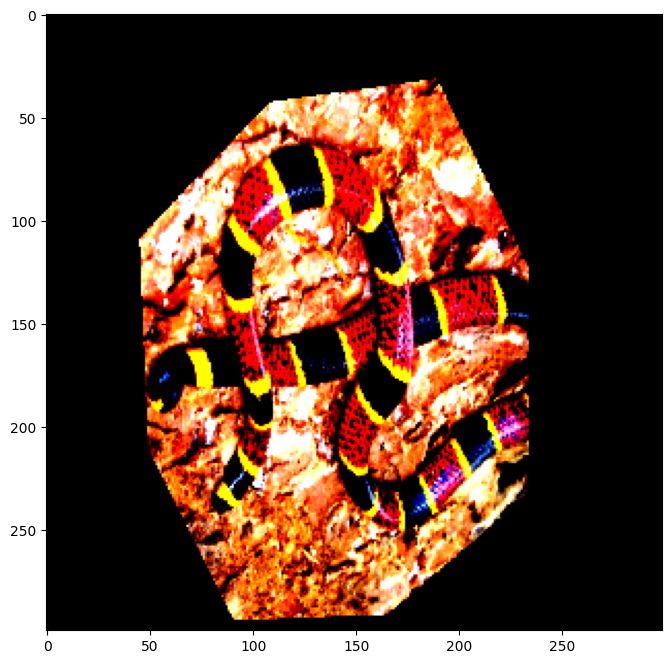

In [56]:
x = Image.open('teste4.jpg').convert('RGB')
x = transformations(x)
label = 'Coral Verdadeira'

print(f'Real Label: {label}')
print(f'Resnet Prediction: {predict(resnet, x)}')
print(f'VGG Prediction: {predict(vgg, image)}')
print(f'Inception Prediction: {predict(inception, image)}')

imshow(x)